#### Imports

In [1]:
import numpy as np
from numpy import pi as π
import scipy as sp
import scipy.integrate as integrate
import scipy.constants as consts
import matplotlib.pyplot as plt
import numba
import ipywidgets
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8,3)
TEST_CONVERGENCES = False

# Nearly Free Electron Model

We are considering free-electron waves perturbed by a periodic potential of atoms in a solid. Our Hamiltonian is

$$
\pmb{\mathcal{H}} = \pmb{\mathcal{H}}_0+V(\mathbf{r})
$$

where $\pmb{\mathcal{H}}_0 = \frac{\mathbf{p}^2}{2m}$ and $V(\mathbf{r})=V(\mathbf{r}+\mathbf{R})$

The matrix elements of $V(\mathbf{r})$ are expressed as

$$
\braket{k'|V|k} = \frac{1}{L}\int dr \cdot e^{-i(k'-k) r} V(r)\equiv V_{k'-k}
$$

Or, in terms of $G$

$$
V_G \equiv \frac{1}{L}\int dr \cdot e^{-iGr} V(r)
$$

In [2]:
# VG
def V_fourier(G, # point to calculate VG at
              V, # potential to transform
              L=1.0):
    def integrand(r,G=G,V=V,L=L):
        func = 1.0/L * np.exp(-1j*G*r) * V(r)
        return np.real(func) # to get rid of complex warning (gauranteed to be real anyway)
    v,_ = integrate.quad(integrand,0.0,L)
    return v

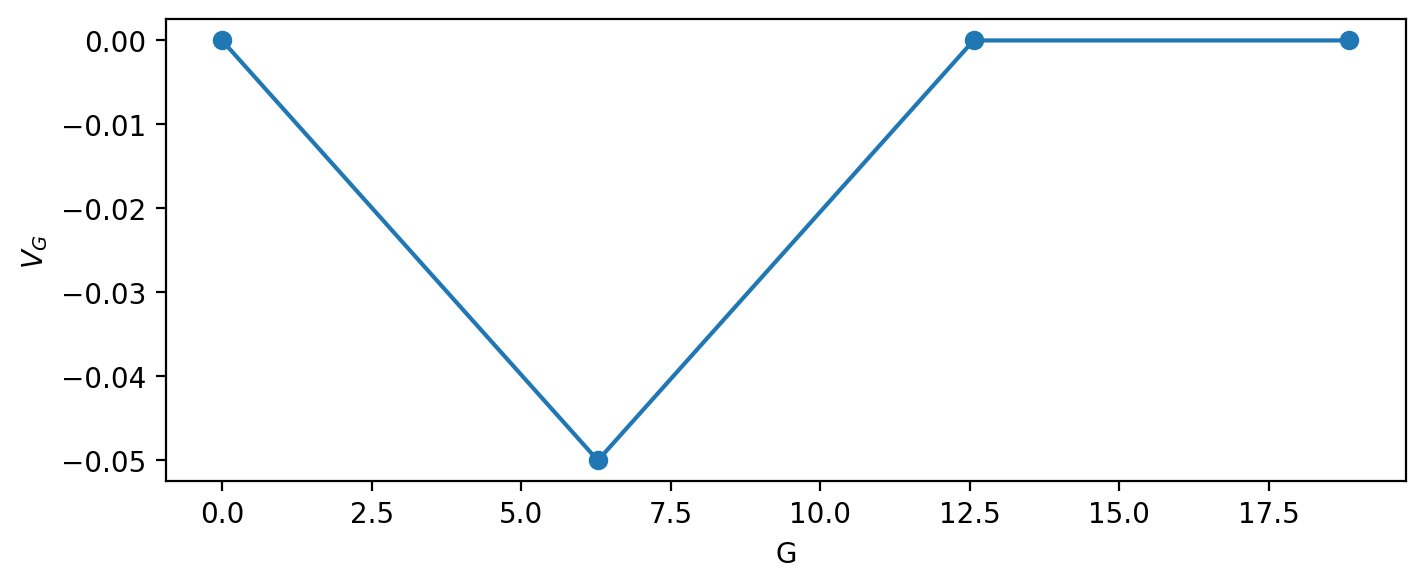

In [3]:
# potential to use for testing
def V_cosine(r,a=1,V0=[-0.1]):
    # iterates the list of coefficients in V0 and returns in the form
    # V00*cos(2πr/a) + V01*cos(4πr/a) + V02*cos(6πr/a) + ···
    return sum([V0n * np.cos(2*(n+1)*π*r/a) for n,V0n in enumerate(V0)])

N = 3
X = np.linspace(0, 2*π*N, N+1)
Y = np.array([V_fourier(x,V_cosine) for x in X])

plt.xlabel('G')
plt.ylabel('$V_G$')
plt.scatter(X,Y)
plt.plot(X,Y);

Now that we can compute $V_G$ for any $G$, we can compute the energy of the system by diagonalizing the following matrix. Both these energy terms are a result from calculations in second order perturbation theory.

$$
\begin{pmatrix}
\varepsilon_0(k) & V_G^*
\\
V_G & \varepsilon_0(k+G)
\end{pmatrix}
$$

where $\varepsilon_0(k)=\frac{\hbar^2|k|^2}{2m}$.

In [4]:
def ε0(k,ħ=1,m=1):
    return ħ**2 * np.abs(k)**2 / (2*m)

def tise(k,G,V):
    a00 = ε0(k)
    a01 = V_fourier(-G,V)
    a10 = V_fourier(G,V)
    a11 = ε0(k+G)
    A = np.array([[a00,a01], [a10,a11]])
    E,Ψ = sp.linalg.eigh(A)
    return E

### Case 1: $k$ Exactly at Zone Boundary

In this case, we have that $k$=$-k'$, so $\varepsilon_0(k)=\varepsilon_0(k+G)$. We should see solutions of $\varepsilon_{\pm}=\varepsilon_0(k)\pm|V_G|$.

In [5]:
n = 2
k = -n*π
G = 2*π*n
E_expected = [ε0(k) + V_fourier(G,V_cosine), ε0(k) - V_fourier(G,V_cosine)]
E_calculated = tise(k,G,V_cosine)
print(f'Expected {E_expected}')
print(f'Calculated {E_calculated}')
print(f'Δ = {E_expected - E_calculated}')

Expected [19.739208802178716, 19.739208802178716]
Calculated [19.7392088 19.7392088]
Δ = [0. 0.]


### Case 2: $k$ Almost at Zone Boundary

Now, we shift $k=\frac{n\pi}{a} \rightarrow \frac{n\pi}{a} + \delta$ for small $\delta$. We should see solutions of $E_{\pm}=\frac{\hbar^2(n\pi/a)^2}{2m} \pm |V_G| + \frac{\hbar^2\delta^2}{2m}\left[1 \pm \frac{\hbar^2(n\pi/a)^2}{m}\frac{1}{|V_G|}\right]$

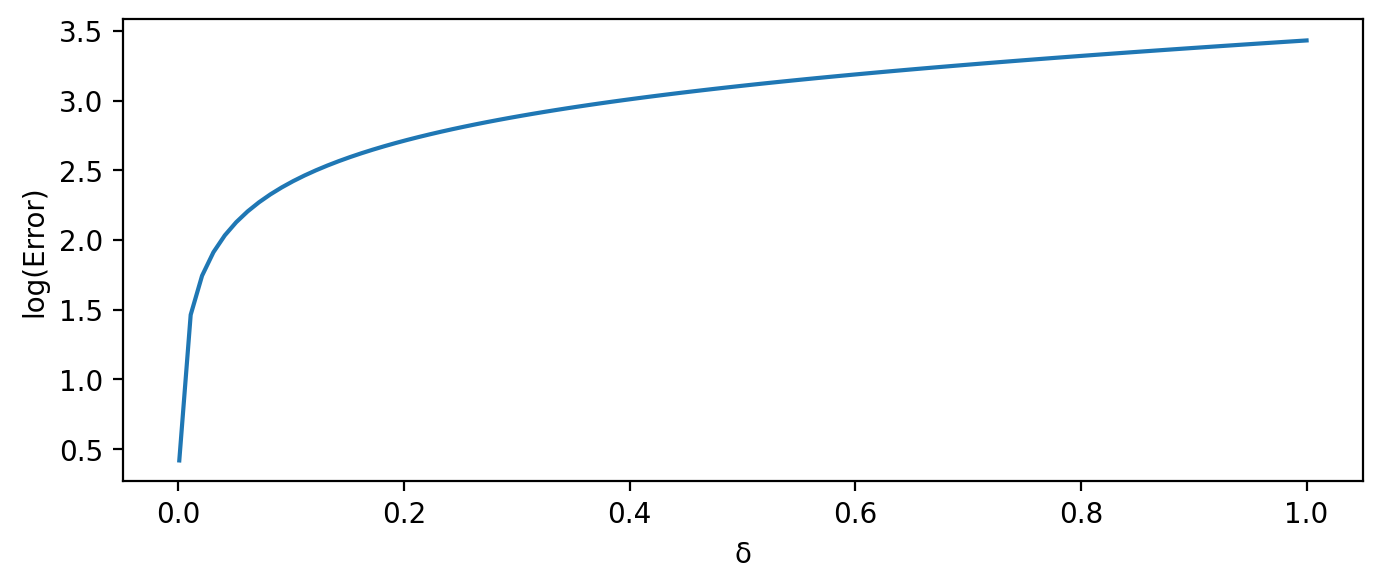

In [6]:
Δ = np.linspace(1e-3,1,100)
Error = np.empty(100)

for i,δ in enumerate(Δ):
    absVG = np.abs(V_fourier(G-δ,V_cosine))
    E_exp_pos = ε0(k) - absVG + δ**2/2 * (1 - 2*ε0(k)/absVG)
    E_exp_neg = ε0(k) + absVG + δ**2/2 * (1 + 2*ε0(k)/absVG)
    E_acc_pos, E_acc_neg = tise(k+δ,G,V_cosine)
    
    δ_pos = E_exp_pos - E_acc_pos
    δ_neg = E_exp_neg - E_acc_neg
    Error[i] = np.sqrt(δ_pos**2 + δ_neg**2)

plt.figure()
plt.xlabel('δ')
plt.ylabel('log(Error)')
plt.plot(Δ,np.log10(Error));

# Bloch's Theorem

The above code simulates a "free" electron along with a weakly perturbed potential. This is not realistic. We will use Bloch's Theorem to more accurately paint the picture of what is going on.

Bloch's Theorem states that an electron in a periodic potential has eigenstates in the form
$$
\Psi_k^\alpha(\mathbf{r}) = e^{i\mathbf{k}\cdot\mathbf{r}}u_k^\alpha(\mathbf{r})
$$

Where $u_k^\alpha(\mathbf{r})$ is periodic in the unit cell. Because of this, we can express it as
$$
u_k^\alpha(\mathbf{r}) = \sum_{G}\psi_{G,k}^\alpha e^{i\mathbf{G}\cdot\mathbf{r}} \ \ \ \implies \ \ \ \Psi_k^\alpha(\mathbf{r}) = \sum_{G}\psi_{G,k}^\alpha e^{i(\mathbf{G}+\mathbf{k})\cdot\mathbf{r}}
$$

To clean this up, we will focus only on the 1-dimensional case, and we will more conveniently write $\Psi_k$ as (using the fact that both $k,G\in(-\infty,\infty)$):
$$
\Psi_{k'}(x)=\sum_{k'}\psi_{k',k}e^{ik'x}
$$

Also, since our periodic is potential, we can also expand it into a Fourier Series
$$
V(x)=\sum_GV_Ge^{iGx}
$$

We can insert these into the TISE:
$$
\begin{align}
\left[\frac{\hat{p}^2}{2m}+V(\hat{x})\right]\Psi(x) &= E\Psi(x) \\
-\frac{\hbar^2}{2m}\frac{d^2}{dx^2}\sum_{k'}\psi_{k',k}e^{ik'x} + \left(\sum_G V_Ge^{iGx}\right)\left(\sum_{k'}\psi_{k',k}e^{ik'x}\right) &= E_k\sum_{k'}\psi_{k',k}e^{ik'x} \\
\frac{\hbar^2}{2m}\sum_{k'}(k')^2\psi_{k',k}e^{ik'x} + \sum_{G,k'}V_G\psi_{k',k}e^{i(G+k')x} &= E_k\sum_{k'}\psi_{k',k}e^{ik'x}
\end{align}
$$

For the term summing over $G$, we will define $m := (G+k')\in(-\infty,\infty)$. We will then Fourier transform both sides. Note that $\int_{\mathbb{R}}e^{i(k'-k)x}dx = 2\pi\delta(k'-k)$.

$$
\begin{align}
\frac{\hbar^2}{2m}\sum_{k'}(k')^2\psi_{k',k}e^{ik'x} + \sum_{G,m}V_G\psi_{m-G,k}e^{imx} &= E_k\sum_{k'}\psi_{k',k}e^{ik'x} \\
\frac{\hbar^2}{2m}\sum_{k'}(k')^2\psi_{k',k}\delta(k'-k) + \sum_{G,m}V_G\psi_{m-G,k}\delta(m-k) &= E_k\sum_{k'}\psi_{k',k}e^{ik'x}\delta(k'-k) \\
\frac{\hbar^2}{2m}k^2\psi_{k,k} + \sum_GV_G\psi_{k-G,k} &= E_k\psi_{k,k}
\end{align}
$$

Finally, rearranging leaves us with the central equation

$$
\sum_GV_G\psi_{k-G}=\left(E_k-\frac{\hbar^2k^2}{2m}\right)\psi_k
$$

Let's define a function `construct_V_fourier(k,Gc)` to construct

$$
\sum_GV_G\psi_{k-G} + \frac{\hbar^2k^2}{2m}\psi_{k} = 
\begin{pmatrix}
    \frac{\hbar^2}{2m}(k-G_c)^2 & V^*_{G_0} & V^*_{2G_0} & \cdots & V_{2G_c}^* \\
    V_{G_0} & \frac{\hbar^2}{2m}(k-G_c+G_0)^2 & V^*_{G_0} & \cdots & V_{2G_c-G_0}^* \\
    V_{2G_0} & V_{G_0} & \ddots & & \vdots \\
    \vdots & \vdots &  & \ddots & \vdots \\
    V_{2G_c} & V_{2G_c-G_0} & \cdots & \cdots & \frac{\hbar^2}{2m}(k+G_c)^2 \\
\end{pmatrix}
\begin{pmatrix}
    \psi_{k-G_c} \\
    \psi_{k-G_c+G_0} \\
    \vdots \\
    \psi_{k} \\
    \vdots \\
    \psi_{k+G_c}
\end{pmatrix}
$$

where $G_0\equiv2\pi/a$ represents the smallest distance between lattice points and $G_c\equiv2\pi n_c/a$ is a chosen computational bound on the lattice. In reality, $G_c$ does not exist and is infinite.

In order to not worry about how the matrix is indexed, I will rewrite the central equation as:
$$
\begin{align}
\sum_GV_G\Psi_{k-G} &= \left(E_k-\frac{\hbar^2|k|^2}{2m}\right)\Psi_k \\
\sum_GV_{G}\Psi_{k-G'-G} &= \left(E_k - \frac{\hbar^2|k-G'|^2}{2m}\right)\Psi_{k-G} \\
\sum_GV_{G-G'}\Psi_{k-G'} &= \left(E_k - \frac{\hbar^2|k-G'|^2}{2m}\right)\Psi_{k-G}
\end{align}
$$

and will write `construct_V_fourier` to construct $\left(\sum_GV_{G-G'}+\frac{\hbar^2}{2m}\left|k-G'\right|\right)$. Note that this is equivalent to the form written above, but a lot easier to implement.

In [7]:
#@numba.njit
def construct_V_fourier(k,           # point at which to compute Σ(V_G*ψ_{k-G})
                        nc,          # cut-off/bound
                        V=V_cosine,  # potential function
                        ħ=1,m=1,a=1):
    G0 = 2*π/a
    N  = 2*nc + 1
    ns = np.arange(N,dtype=float) - nc
    
    V_cache = {}
    VG = np.zeros((N,N))
    for i,ni in enumerate(ns):
        k0 = k - G0*ni
        VG[i,i] += ε0(k0)
        for j,nj in enumerate(ns):
            nij = ni-nj
            if nij not in V_cache:
                V_cache[nij] = V_fourier(G0*nij,V,L=a) # TODO: L=Na?
            VG[i,j] += V_cache[nij]
    return VG

Now this can be used to solve the TISE

In [8]:
def solve_tise(K,nc,V=V_cosine,a=1,index=None):
    N = len(K)
    E = np.zeros((N, 2*nc+1))
    Ψ = np.zeros(((N, 2*nc+1, 2*nc+1)))
    for i,k in enumerate(K):
        VG = construct_V_fourier(k,nc,V=V,a=a)
        E[i],Ψ[i] = sp.linalg.eigh(VG)
        
    if index == None:
        return E,Ψ
    else:
        return E[index],Ψ[index]

a = 1
V = lambda x: V_cosine(x,V0=[-0.1],a=a)
nc = 20                            # cutoff
N = 100                             # number of points on grid ("resolution")
K = np.linspace(-1,1,N+1) * π/a    # range of k values in the first Brilloin zone

E,Ψ = solve_tise(K,nc,V,a=a)

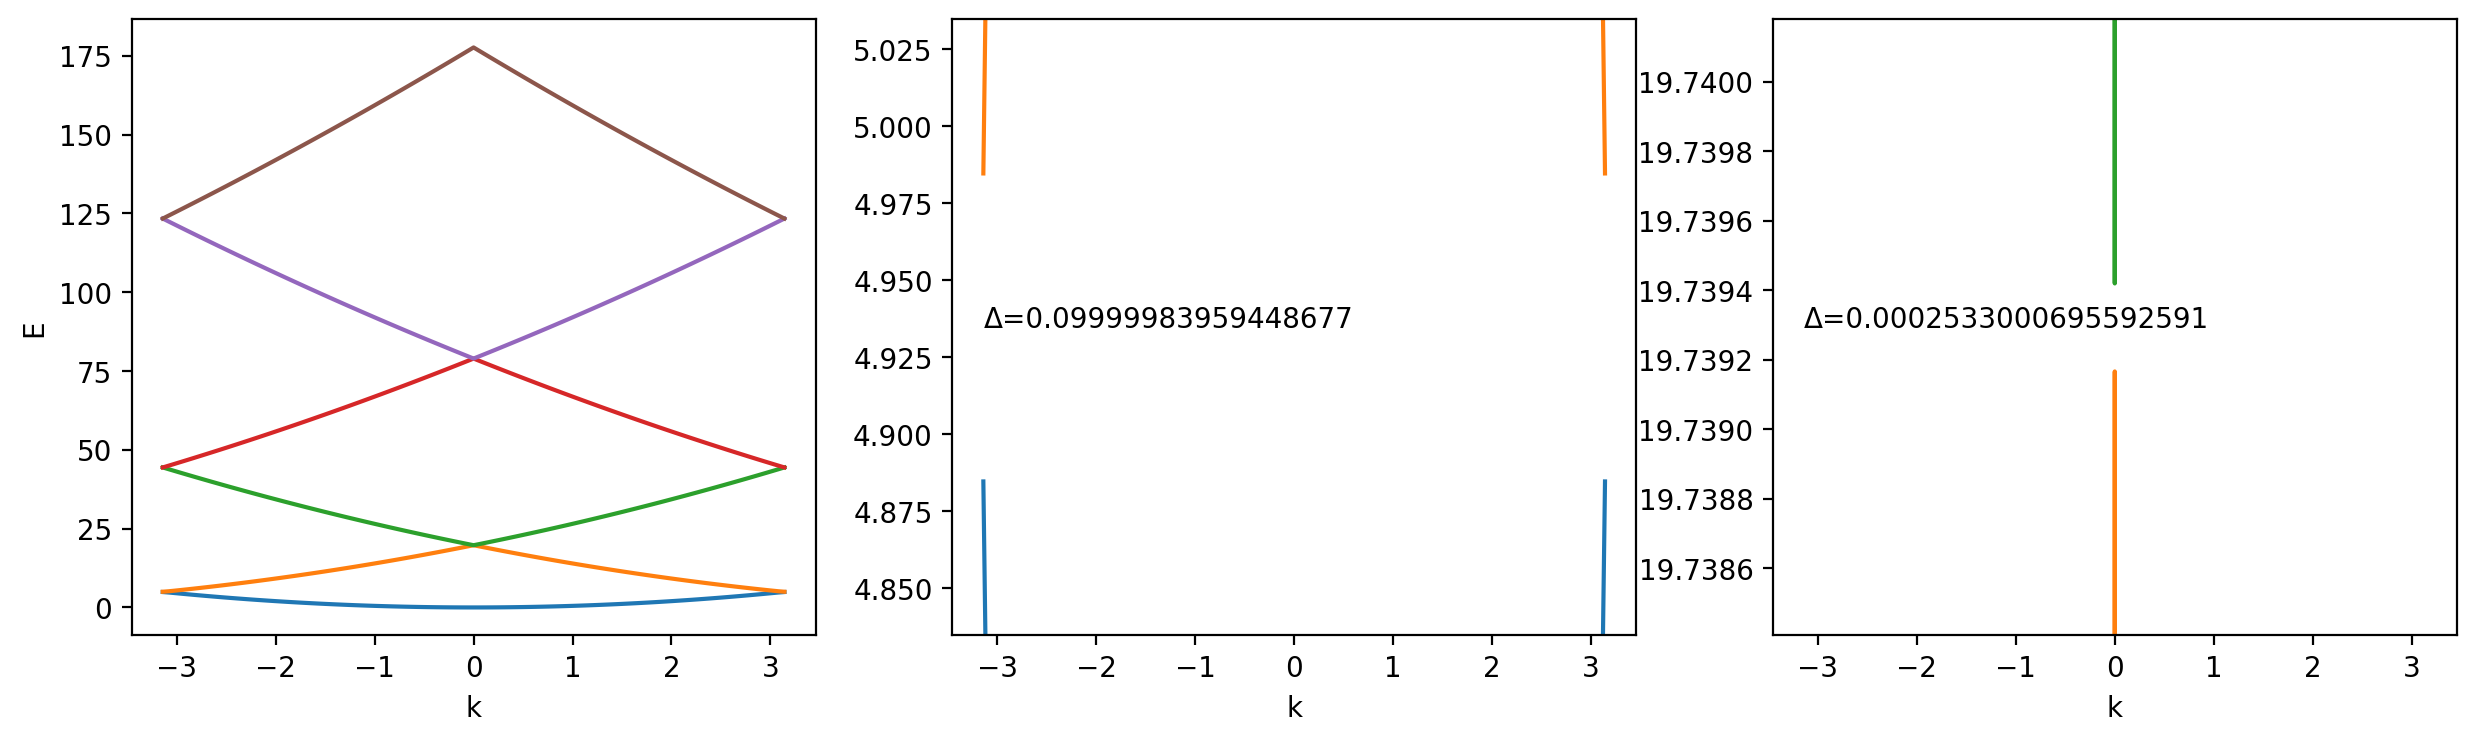

In [9]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.xlabel('k')
plt.ylabel('E')
plt.plot(K,E[:,:6])
    
plt.subplot(1,3,2)
plt.xlabel('k')
ΔE = E[0,1] - E[0,0]
plt.annotate(f'Δ={ΔE}', (K[0], E[0,0] + ΔE/2))
plt.ylim(E[0,0]-ΔE/2, E[0,1]+ΔE/2)
plt.plot(K,E[:,:2]);

plt.subplot(1,3,3)
plt.xlabel('k')
ΔE = E[len(E)//2,2] - E[len(E)//2,1]
plt.annotate(f'Δ={ΔE}', (K[0], E[len(E)//2,1] + ΔE/2))
plt.ylim(E[len(E)//2,1]-ΔE*3, E[len(E)//2,2]+ΔE*3)
plt.plot(K,E[:,:3]);

### Convergence Test

How large must we choose $n_c$ so that the energies and eigenvectors converge?

Note that this minimum value of $n_c$ depends on the strength of our potential and the lattice spacing. (Q: How to handle this?)

In [10]:
k0 = π/a
V0 = -0.37
V = lambda x: V_cosine(x,V0=[V0],a=a)
ncs = np.arange(2,30)
nE = 5

if TEST_CONVERGENCES:
    E = np.empty((len(ncs),nE))
    Ψ = np.empty((len(ncs),nE))
    E0,Ψ0 = solve_tise([k0],ncs[-1]+1,V=V,index=0,a=a)
    
    for i,nc in enumerate(ncs):
        ε,φ = solve_tise([k0],nc,V=V,index=0,a=a)
        E[i] = np.abs(ε[:nE] - E0[:nE])
        Ψ[i] = np.abs(φ[:,:nE][len(ε)//2]) - np.abs(Ψ0[:,:nE][len(E0)//2])
        Ψ[i] = np.abs(Ψ[i])
    
    plt.figure(figsize=(16,5))
    
    plt.subplot(1,2,1)
    plt.xlabel(r'$n_c$')
    plt.ylabel(rf'$\log(E - E_{{n_c={ncs[-1] + 1}}})$')
    plt.title(f'Energies (first {nE})')
    plt.plot(ncs, np.log10(E))
    
    plt.subplot(1,2,2)
    plt.xlabel(r'$n_c$')
    plt.ylabel(rf'$\log(\psi - \psi_{{n_c={ncs[-1] + 1}}})$')
    plt.title(f'Eigenvectors (first {nE})')
    plt.plot(ncs, np.log10(Ψ));
    f'V(x)= {V0}cos(2πx/a), a={a}'

### Sanity Check: Comparison to Literature

[This paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.043839) (Wu et al., 2015) used a periodic potential $V(x)=-V_0\left[1+\cos(2\pi x/a)\right]$ with $V_0=0.37$ and $a=8$ (both in atomic units). They saw a minimum band gap of 4.2 eV.

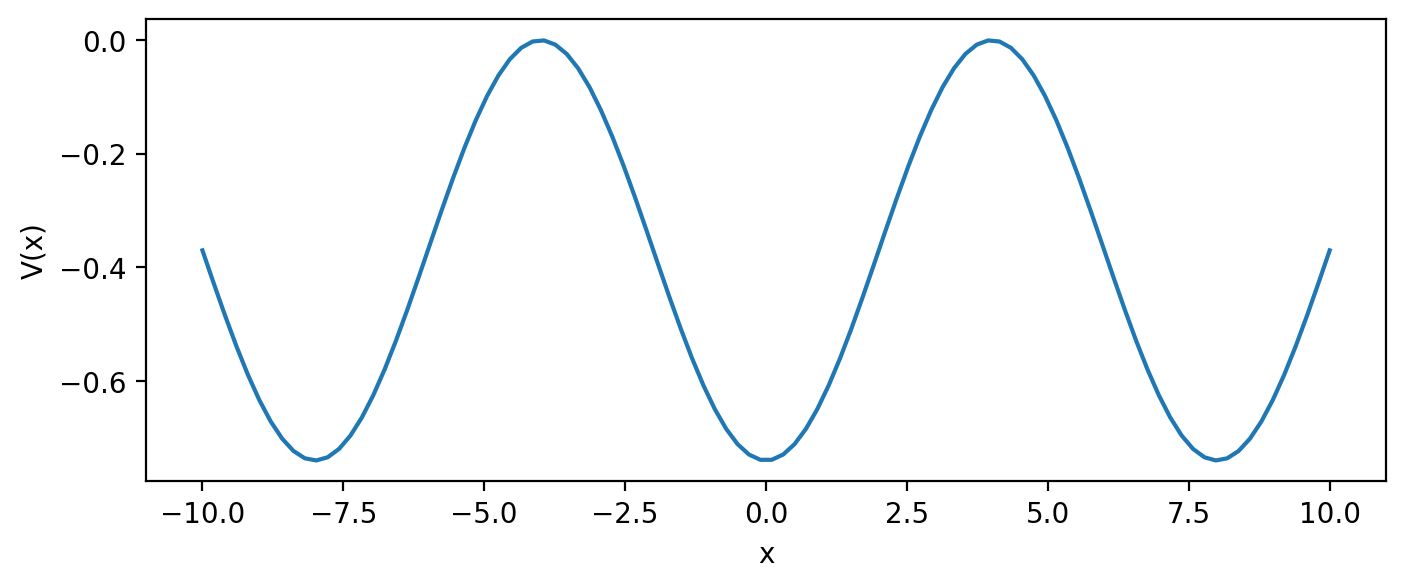

In [11]:
def V_Wu(x,a=8,V0=0.37):
    return -V0 * (1 + np.cos(2*π*x/a))

X = np.linspace(-10,10,100)
plt.xlabel('x')
plt.ylabel('V(x)')
plt.plot(X,V_Wu(X));

In [12]:
AU_TO_EV = 27.211324570273

In [13]:
a = 8
nc = 25
N = 100
K = np.linspace(-1,1,N+1) * π/a

E,Ψ = solve_tise(K,nc,V_Wu,a=a)
E_eV = AU_TO_EV*E # au to eV

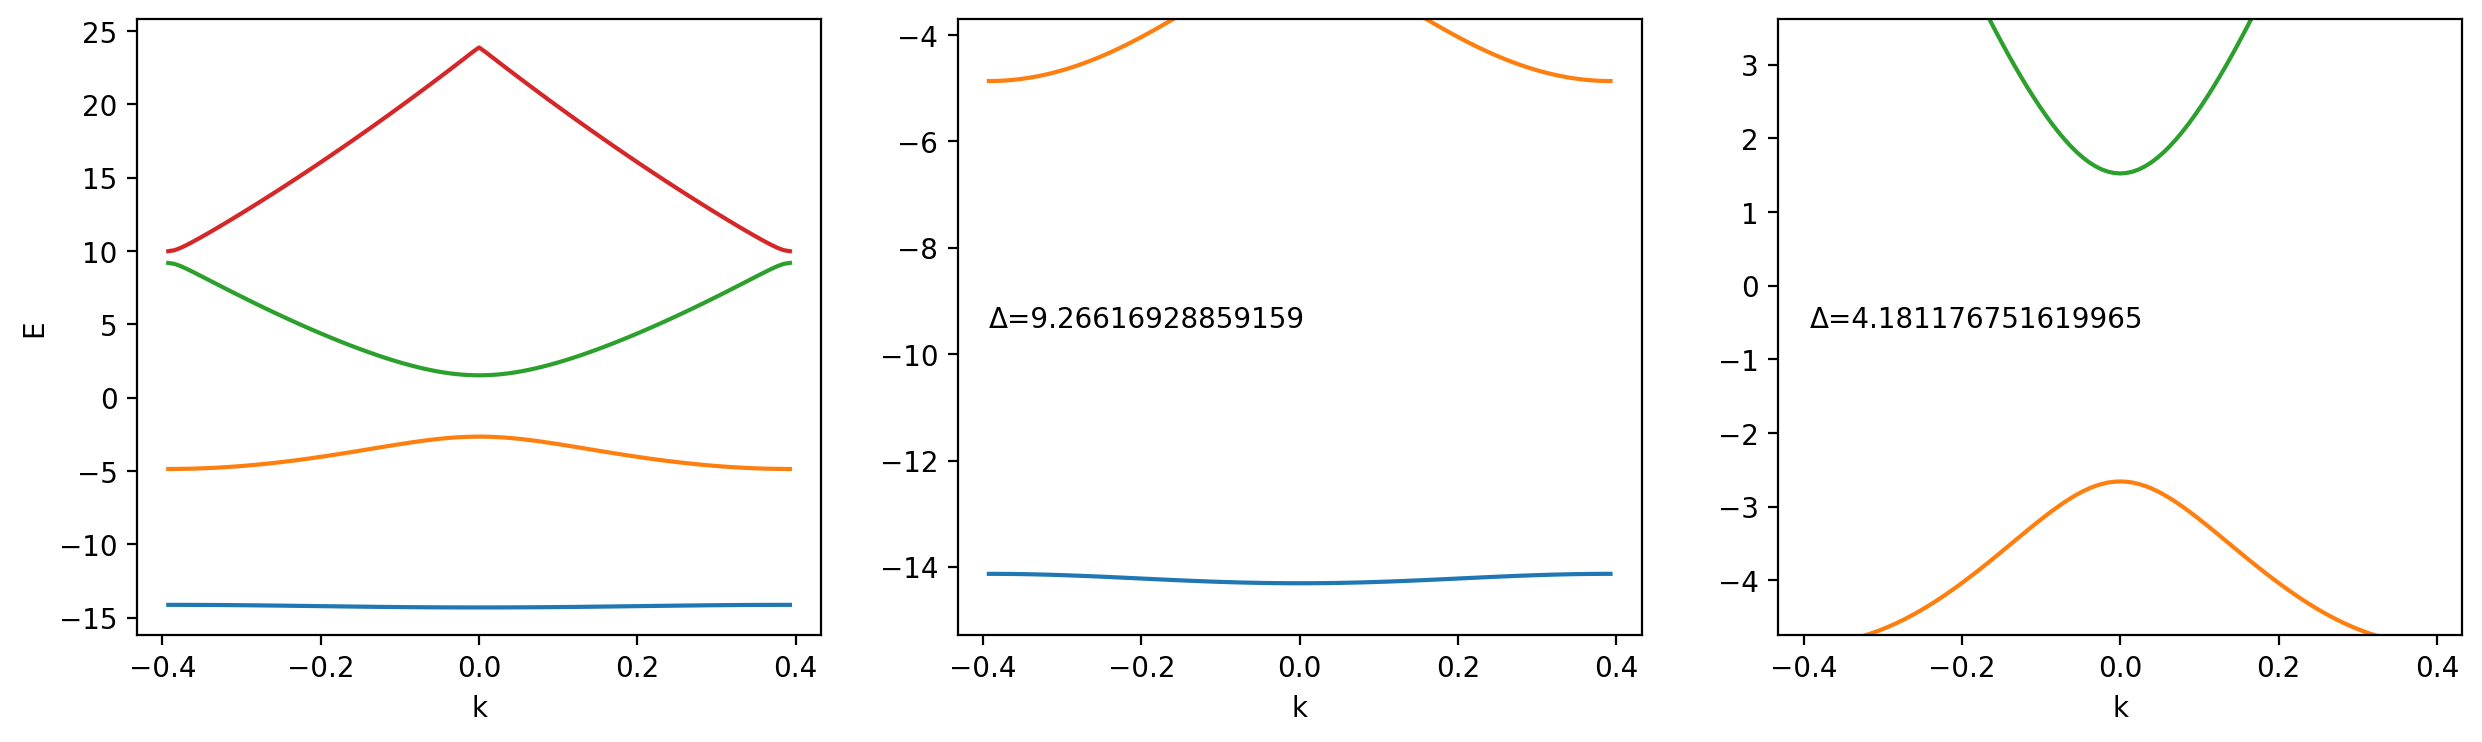

In [14]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.xlabel('k')
plt.ylabel('E')
plt.plot(K,E_eV[:,:4])
    
plt.subplot(1,3,2)
plt.xlabel('k')
k0 = 0
ΔE = E_eV[k0,1] - E_eV[k0,0]
plt.annotate(f'Δ={ΔE}', (K[0], E_eV[k0,0] + ΔE/2))
plt.ylim(E_eV[k0,0]-ΔE/8, E_eV[k0,1]+ΔE/8)
plt.plot(K,E_eV[:,:2]);

plt.subplot(1,3,3)
plt.xlabel('k')
k0 = len(E_eV)//2
ΔE = E_eV[k0,2] - E_eV[k0,1]
plt.annotate(f'Δ={ΔE}', (K[0], E_eV[k0,1] + ΔE/2))
plt.ylim(E_eV[k0,1]-ΔE/2,E_eV[k0,2]+ΔE/2)
plt.plot(K,E_eV[:,:3]);

### 2-Dimensional Case

Our central equation remains in the same form (now in 2D)
$$
\sum_\vec{G}V_{\vec{G}-\vec{G}'}\Psi_{\vec{k}-\vec{G}'} = \left(E - \frac{\hbar^2|\vec{k}-\vec{G}'|^2}{2m}\right)\Psi_{\vec{k}-\vec{G}}
$$

Where $\vec{k}=m_1a_1 + m_2a_2$ with $m_1,m_2\in\left[-\frac{\pi}{a},\frac{\pi}{a}\right]$ and $\vec{G}=n_1b_1+n_2b_2$ with $n_1,n_2\in\left[-\frac{2\pi}{a}n_c, \frac{2\pi}{a}n_c\right]$ and $n_c$ is the integer corresponding to the limit $G_c$.

We now calculate the Fourier components of the potential with
$$
V_\vec{G} = \frac{1}{A}\int d^2r \  e^{-i\vec{G}\cdot\vec{r}}\equiv\frac{1}{L^2}\int_0^L\int_0^Ldx_1dx_2 \ e^{-i(n_1b_1+n_2b_2)\cdot(x_1a_1+x_2a_2)} V(x_1,x_2)
$$

Which, by using the identity $a_i\cdot b_j=2\pi\delta_{ij}$, simplifies to
$$
V_\vec{G} = \frac{1}{L^2}\int_0^L\int_0^Ldx_1dx_2 \ e^{-i2\pi(n_1x_1 + n_2x_2)}V(x_1,x_2)
$$

In [15]:
def V_fourier2D(G,V,L=1.0):
    def integrand(x1,x2,G=G,V=V,L=L):
        G1,G2 = G
        func = 1.0/L**2 * np.exp(-1j*(G1*x1 + G2*x2)) * V(x1,x2)
        return np.real(func) # to get rid of complex warning
    v,_ = integrate.dblquad(integrand, 0.0,L,0.0,L)
    return v

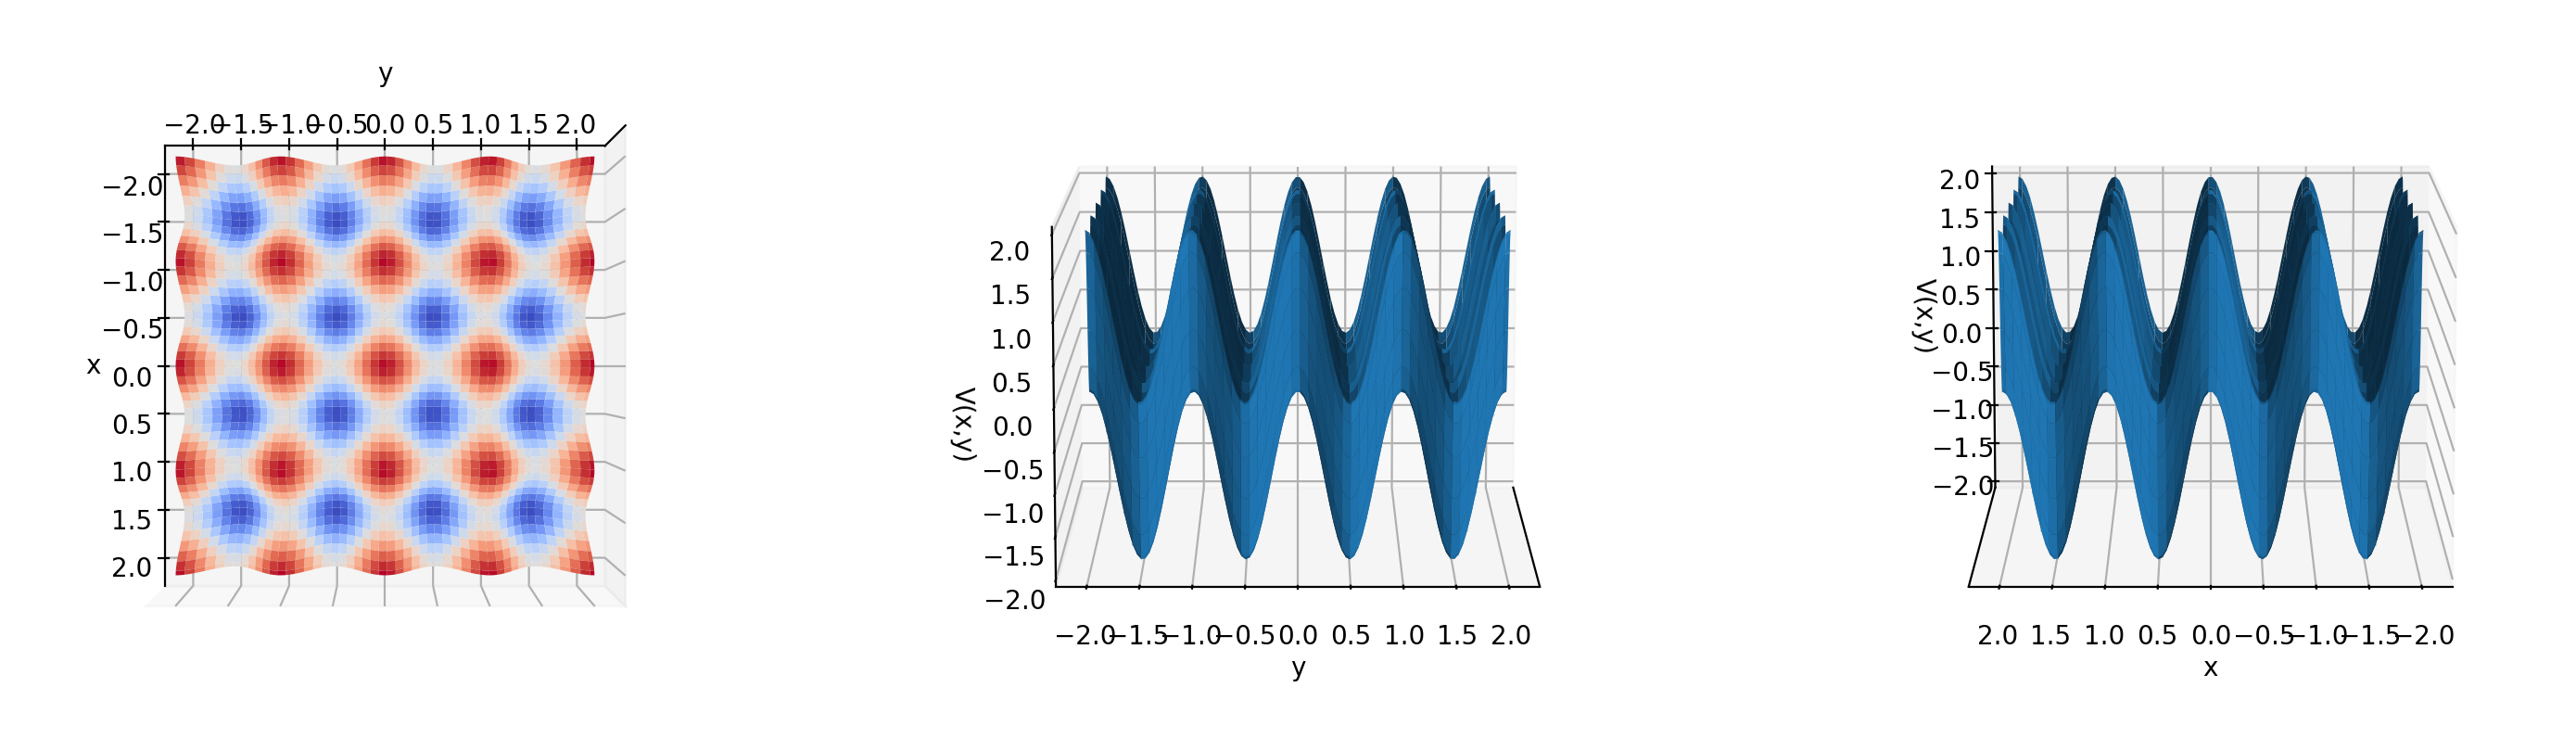

In [16]:
def V_cosine2D(x1,x2,a=1,V10=1,V11=1):
    V1 = V10*np.cos(2*π*x1/a) + V11*np.cos(2*π*x2/a)
    V2 = 2*V10*V11*np.cos(2*π*x1/a)*np.cos(2*π*x2/a)
    return V1 #+ V2

def V_gaussian2D(x1,x2,a=1,V10=-5,width=0.5):
    return V10*np.exp(-((x1)**2 + (x2)**2)/2/0.5**2)

a = 1
V2D = V_cosine2D

X = Y = np.linspace(-2,2,100)
mX,mY = np.meshgrid(X,Y)
plt.figure(figsize=(18,5))

ax = plt.subplot(1,3,1, projection='3d')
V = V2D(mX,mY,a=a)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zticks([])
ax.plot_surface(mX,mY,V,cmap='coolwarm')
ax.view_init(90,0,0)

ax = plt.subplot(1,3,2, projection='3d')
V = V2D(mX,mY,a=a)
ax.set_ylabel('y')
ax.set_zlabel('V(x,y)')
plt.xticks([])
ax.plot_surface(mX,mY,V)
ax.view_init(10,0,0)

ax = plt.subplot(1,3,3, projection='3d')
V = V2D(mX,mY,a=a)
ax.set_xlabel('x')
ax.set_zlabel('V(x,y)')
plt.yticks([])
ax.plot_surface(mX,mY,V)
ax.view_init(10,90,0)

Since we will be calculating the Fourier components multiple times, it makes sense to store them in a cache. Instead of rebuilding the cache each time `construct_V_fourier2D` is run, we can store it globally.

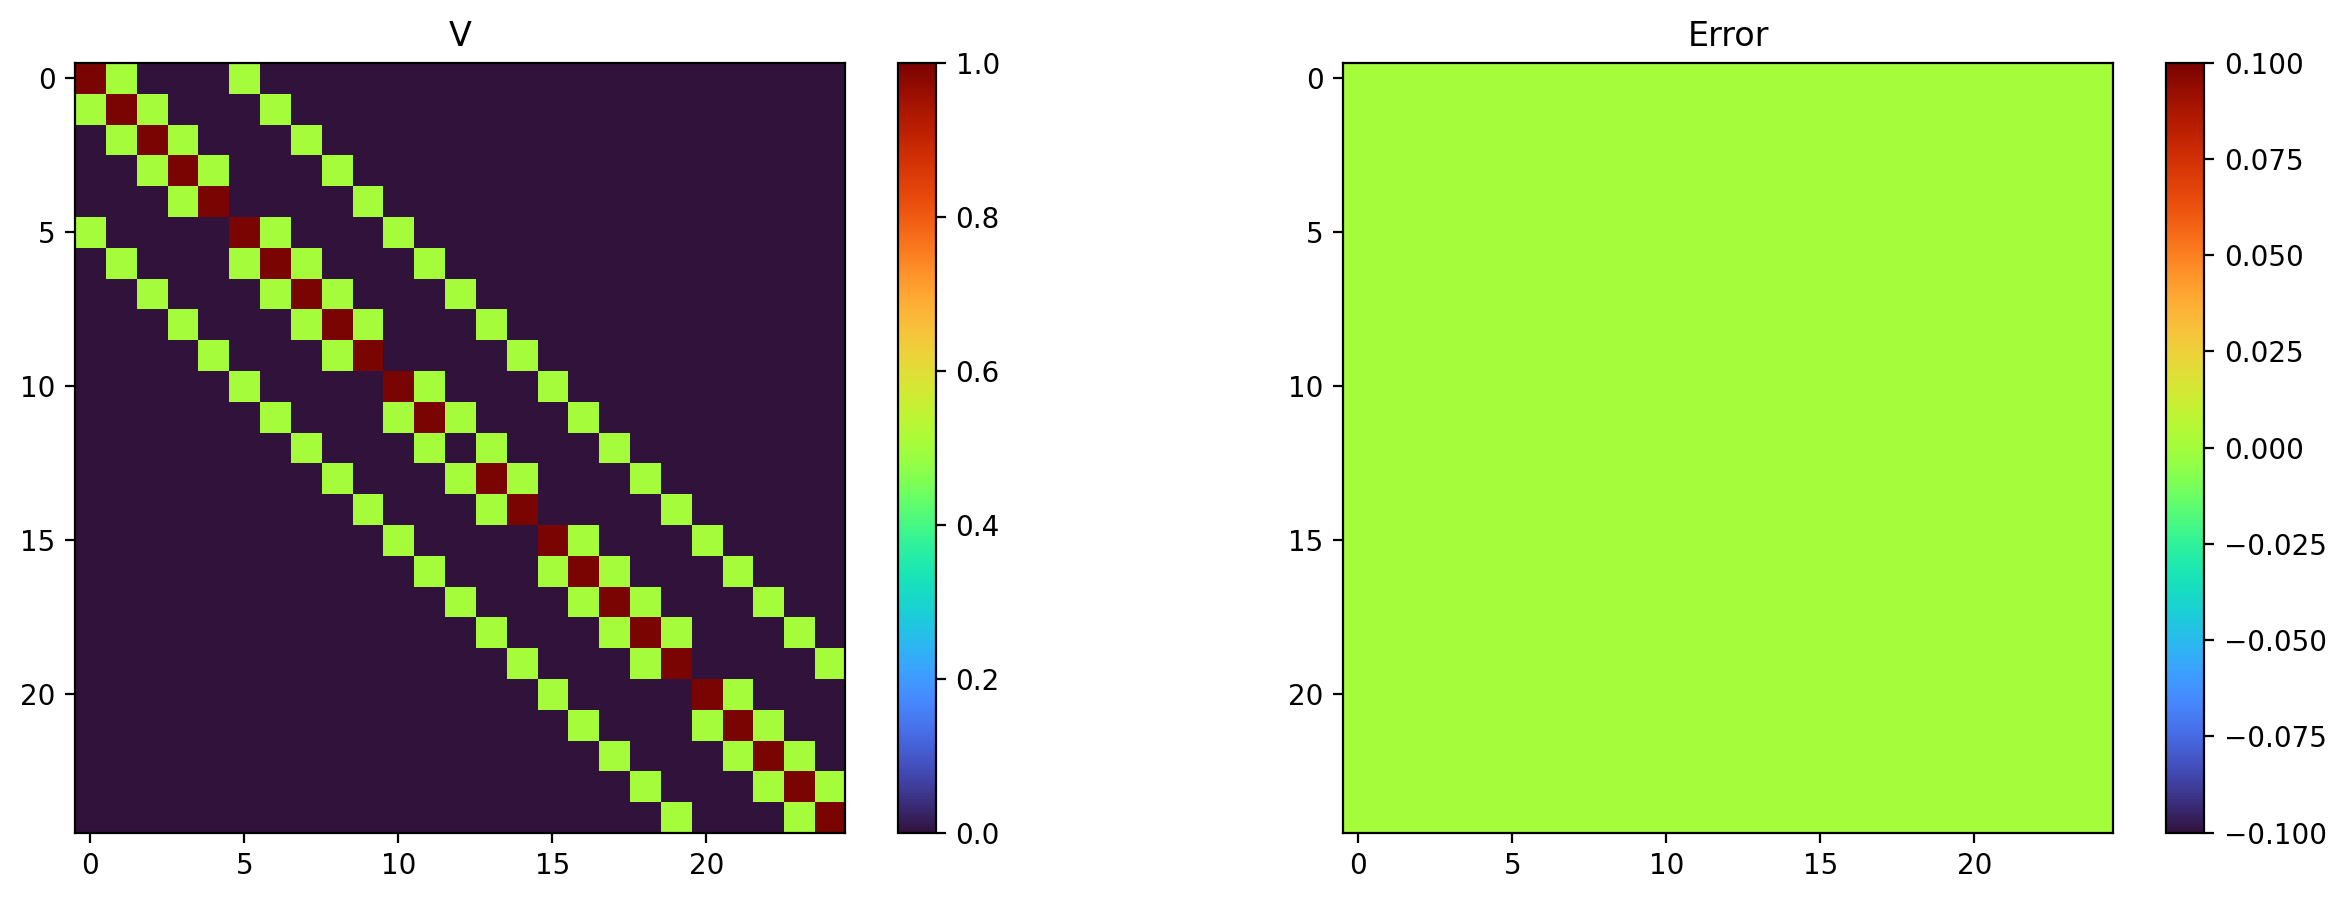

In [17]:
global V_cache
V_cache = {}
V_cache_func = V_cosine2D

def construct_V_fourier2D(k,                     # point at which to compute Σ(V_{G-G'} * Ψ_{k-G'})
                          nc,                    # cut-off/bound
                          V=V_cosine2D,          # potential function
                          ħ=1,m=1,a=1,
                          opt=True,
                          fix_ky=None
                         ):
    G0 = 2*π/a
    N  = 2*nc + 1
    ns = np.empty(N**2, dtype=object)

    # generate all integers to be multiplied by G0
    for nx in range(N):
        for ny in range(N):
            i = nx*N + ny
            ns[i] = np.array([nx-nc, ny-nc])

    global V_cache,V_cache_func
    # if different potential is passed in (and thus cache is now invalid)
    if V != V_cache_func:
        print('resetting cache')
        V_cache = {}
        V_cache_func = V
    
    VG = np.zeros((N**2,N**2))

    if opt:
        for i,ni in enumerate(ns):
            k1,k2 = k-G0*ni
            k2 = k2 if (fix_ky == None) else fix_ky
            VG[i,i] += ε0(k1) + ε0(k2)
            for j,nj in enumerate(ns):
                nij = tuple(ni-nj)
                if nij not in V_cache:
                    V_cache[nij] = V_fourier2D(G0*(ni-nj),V,L=a) #TODO: L=Na?
                VG[i,j] += V_cache[nij]
                
    # brute force method, to verify if the above algorithm works  
    else: 
        for iG1,G1 in enumerate(G0*ns):
            k1,k2 = k-G1
            VG[iG1,iG1] += (k1**2 + k2**2) / 2  # ħ(k+G1)**2/2/m
            for iG2,G2 in enumerate(G0*ns):
                VG[iG1,iG2] += V_fourier2D(G1-G2,V,L=a)

    return VG

nc = 2
a = 1
VG  = construct_V_fourier2D((0,0),nc,a=a)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1).title.set_text('V')
plt.imshow(VG, cmap='turbo', vmax=1)
plt.colorbar()

plt.subplot(1,2,2).title.set_text('Error')
plt.imshow(1000*(VG - construct_V_fourier2D((0,0),nc,opt=False,a=a)), cmap='turbo')
plt.colorbar();

In [18]:
%time _ = construct_V_fourier2D((0,0),nc,a=a)
%time _ = construct_V_fourier2D((0,0),nc,opt=False,a=a)

CPU times: user 2.55 ms, sys: 381 µs, total: 2.93 ms
Wall time: 723 µs
CPU times: user 4.81 s, sys: 10.6 ms, total: 4.83 s
Wall time: 4.74 s


In [19]:
def solve_tise2D(Kx,Ky,nc,V=V_cosine2D,a=1,index=None):
    Nx = len(Kx)
    Ny = len(Ky)
    nE = (2*nc + 1)**2
    E = np.zeros((Nx,Ny,nE))
    Ψ = np.zeros((Nx,Ny,nE,nE))
    for ix,kx in enumerate(Kx):
        for iy,ky in enumerate(Ky):
            k = np.array([kx,ky])
            VG = construct_V_fourier2D(k,nc,V=V,a=a)
            E[ix,iy], Ψ[ix,iy] = sp.linalg.eigh(VG)
    if index == None:
        return E,Ψ
    else:
        return E[index,index], Ψ[index,index]

nc = 2         # cutoff
N  = 50       # number of points on grid ("resolution")
Kx = Ky = np.linspace(-1,1,N+1) * π/a

E,Ψ = solve_tise2D(Kx,Ky,nc,a=a)

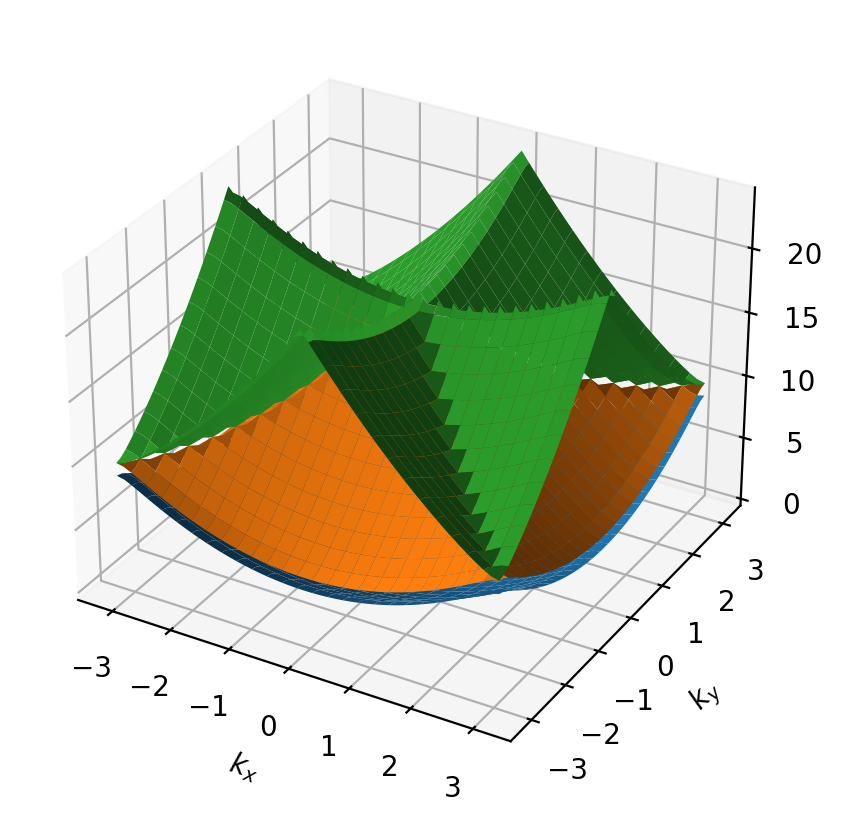

In [20]:
ax = plt.figure(figsize=(12,5)).add_subplot(projection='3d')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E$')

mKx,mKy = np.meshgrid(Kx,Ky)
for ε in range(0,3):
    ax.plot_surface(mKx,mKy,E[:,:,ε])

### Convergence Test

In [21]:
if TEST_CONVERGENCES:
    V = lambda x1,x2: V_cosine2D(x1,x2,V10=1,V11=1,a=a)
    
    k0 = π/a
    ncs = np.arange(nc0:= 2, nc1:= 15)
    nE = (2*nc0 + 1)**2
    
    E0,Ψ0 = solve_tise2D([k0],[k0],nc1,V=V,a=a,index=0)
    
    E = np.empty((len(ncs),nE))
    Ψ = np.empty((len(ncs),nE))
    
    for i,nc in enumerate(ncs):
        ε,φ = solve_tise2D([k0],[k0],nc,V=V,a=a,index=0)
        E[i] = np.abs(ε[:nE] - E0[:nE])
        Ψ[i] = np.abs( np.abs(φ[:,:nE][1]) - np.abs(Ψ0[:,:nE][1]) )
        print(f'{i+1}/{len(ncs)}', end=(' | ' if i+1 != len(ncs) else ''))
    
    plt.figure(figsize=(16,5))
    ylbl = lambda lbl: rf'$\log({lbl} - {lbl}_{{n_c={nc1}}})$'
    
    plt.subplot(1,2,1)
    plt.xlabel(r'$n_c$')
    plt.ylabel(ylbl('E'))
    plt.title(f'Energies (first {nE})')
    plt.plot(ncs, np.log10(E));
    
    plt.subplot(1,2,2)
    plt.xlabel(r'$n_c$')
    plt.ylabel(ylbl('\psi'))
    plt.title(f'Eigenvectors (first {nE})')
    plt.plot(ncs, np.log10(Ψ));

### Sanity Check: Comparison to 1D case

In [22]:
V0 = 4
V1D = lambda x: V_cosine(x,V0=[V0])
V2D = lambda x,y: V_cosine2D(x,0,V10=V0,V11=0)

a  = 1
nc = 5        # cutoff
N  = 50       # number of points on grid ("resolution")

K = Kx = np.linspace(-1,1,N+1) * π/a

nΣ1 = 2*nc + 1
Σ1 = np.zeros((N+1, nΣ1)) # array of 1d energies
for i,k in enumerate(K):
    VG = construct_V_fourier(k,nc,V=V1D,a=a)
    E,Ψ = sp.linalg.eigh(VG)
    Σ1[i] = E

nΣ2 = (2*nc + 1)**2
Σ2 = np.empty((len(Kx), len(Kx), nΣ2)) # array of 2d energies
for ikx,kx in enumerate(Kx):
    k = np.array([kx,0])
    VG = construct_V_fourier2D(k,nc,V=V2D,fix_ky=0,a=a)                
    E,Ψ = sp.linalg.eigh(VG)
    Σ2[ikx,:,:] = E

resetting cache


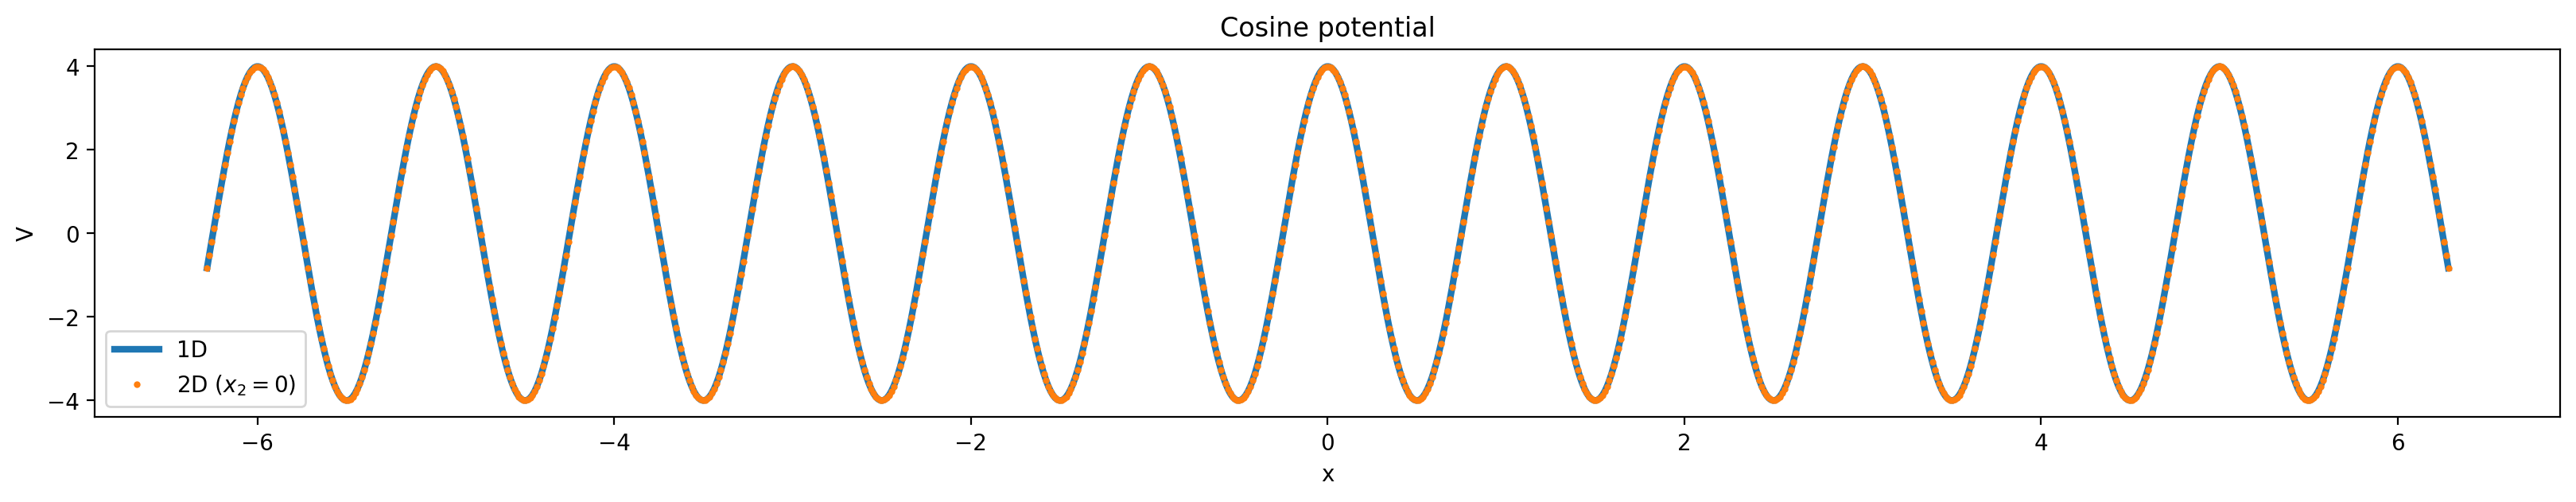

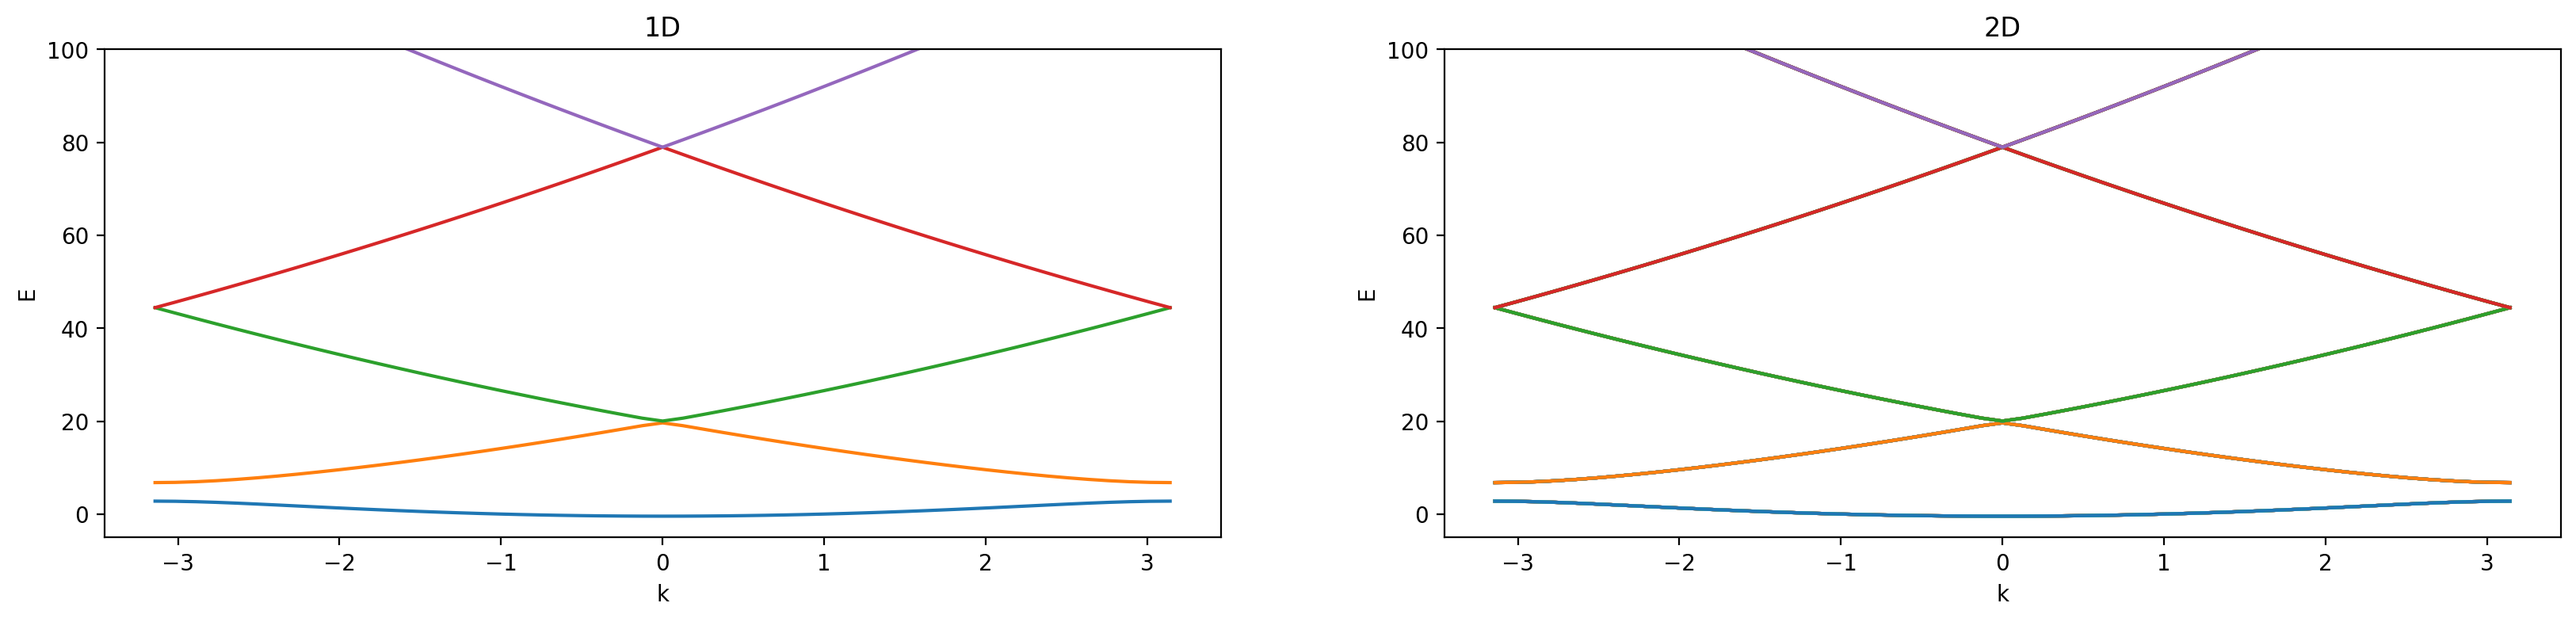

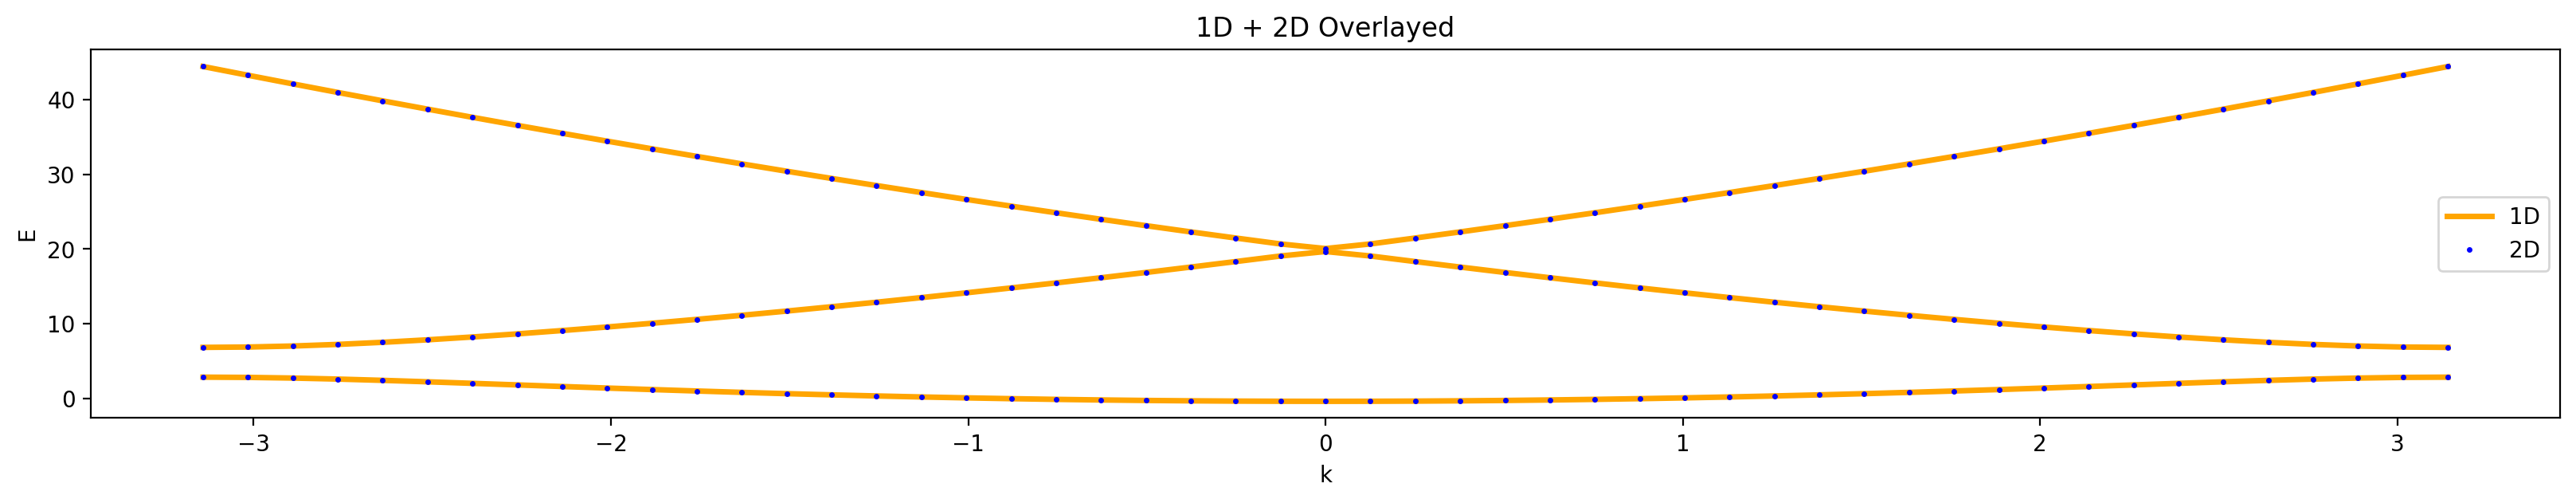

In [23]:
plt.figure(figsize=(20,3))

X = np.linspace(-2*π,2*π,1000)
plt.title('Cosine potential')
plt.xlabel('x')
plt.ylabel('V')
plt.plot(X, V1D(X), label=r'1D', linewidth=3)
plt.plot(X, V2D(X,0), 'o', label=r'2D ($x_2=0$)', markersize=2)
plt.legend()

plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.title('1D')
plt.xlabel('k')
plt.ylabel('E')
plt.ylim(-5,100)
for i in range(nΣ1):
    plt.plot(K,Σ1[:,i])

plt.subplot(1,2,2)
plt.title('2D')
plt.xlabel('k')
plt.ylabel('E')
plt.ylim(-5,100)
for i in range(nΣ2):
    plt.plot(Kx,Σ2[:,0,i])

plt.figure(figsize=(20,3))
plt.title('1D + 2D Overlayed')
plt.xlabel('k')
plt.ylabel('E')
plt.plot(K, Σ1[:,0],linewidth=2.5, label='1D', color='orange')
plt.plot(K, Σ1[:,1],linewidth=2.5, color='orange')
plt.plot(K, Σ1[:,2],linewidth=2.5, color='orange')
plt.plot(Kx, Σ2[:,0,0], 'o', color='b', label='2D', markersize=1.5)
plt.plot(Kx, Σ2[:,0,nΣ1], 'o', color='b', markersize=1.5)
plt.plot(Kx, Σ2[:,0,2*nΣ1], 'o', color='b', markersize=1.5)
plt.legend();

### Sanity Check: Comparison to Literature

First, I will make sure the 1D case [(from above)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.043839) is reproducable.

In [24]:
a = 8
V = lambda x,y: V_Wu(x)

nc = 6
N = 50
K = np.linspace(-1,1,N+1) * π/a

nE2 = (2*nc + 1)**2
E2 = np.empty((len(K), len(K), nE2))
for i,k in enumerate(K):
    VG = construct_V_fourier2D(np.array([k,0]), nc, V=V, fix_ky=0, a=a)
    E,Ψ = sp.linalg.eigh(VG)
    E2[i,:,:] = AU_TO_EV*E

resetting cache


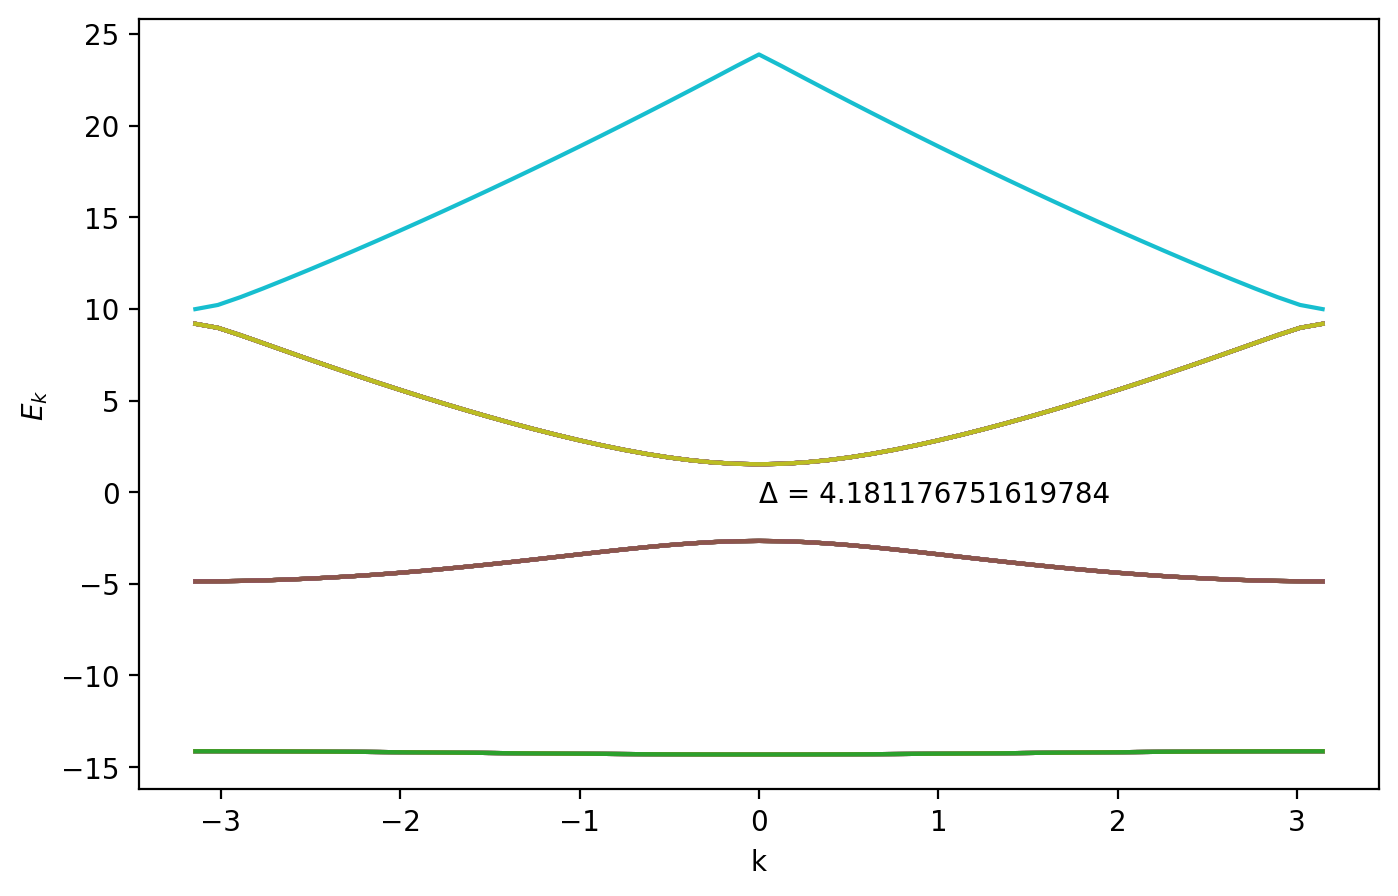

In [25]:
plt.figure(figsize=(8,5))
plt.xlabel('k')
plt.ylabel(r'$E_k$')
Δ = E2[len(E2)//2,0,30] - E2[len(E2)//2,0,25]
plt.annotate(f'Δ = {Δ}', (0, E2[len(E2)//2,0,25] + Δ/2))
plt.plot(Kx, E2[:,0,:40]);

In a [second paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.063412) (Wu et al., 2017), a periodic potential $V(x,y)=-V_0\left[1-\cos(2\pi x/a_x)\right]\left[1-\cos(2\pi y/a_y)\right]$ with $V_0=0.5$ and $a_x=a_y=6$ (both in atomic units) was used.

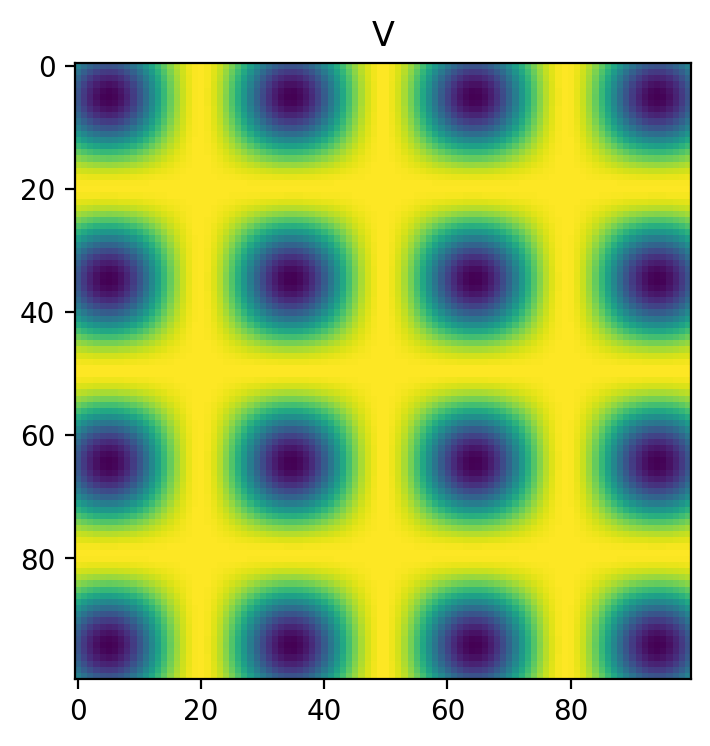

In [26]:
def V_Wu2D(x,y,a=6,V0=0.5):
    return -V0*(1 - np.cos(2*π*x/a))*(1 - np.cos(2*π*y/a))

X = Y = np.linspace(-10,10,100)
mX,mY = np.meshgrid(X,Y)

plt.figure(figsize=(4,4))
V = V_Wu2D(mX,mY)
plt.title('V')
plt.imshow(V);

In [27]:
a = 6
N = 50
K = np.linspace(-1,1,N+1) * π/a
nc = 3
E,Ψ = solve_tise2D(K,K,nc,V_Wu2D,a=6)
E_eV = AU_TO_EV*E # au to eV

resetting cache


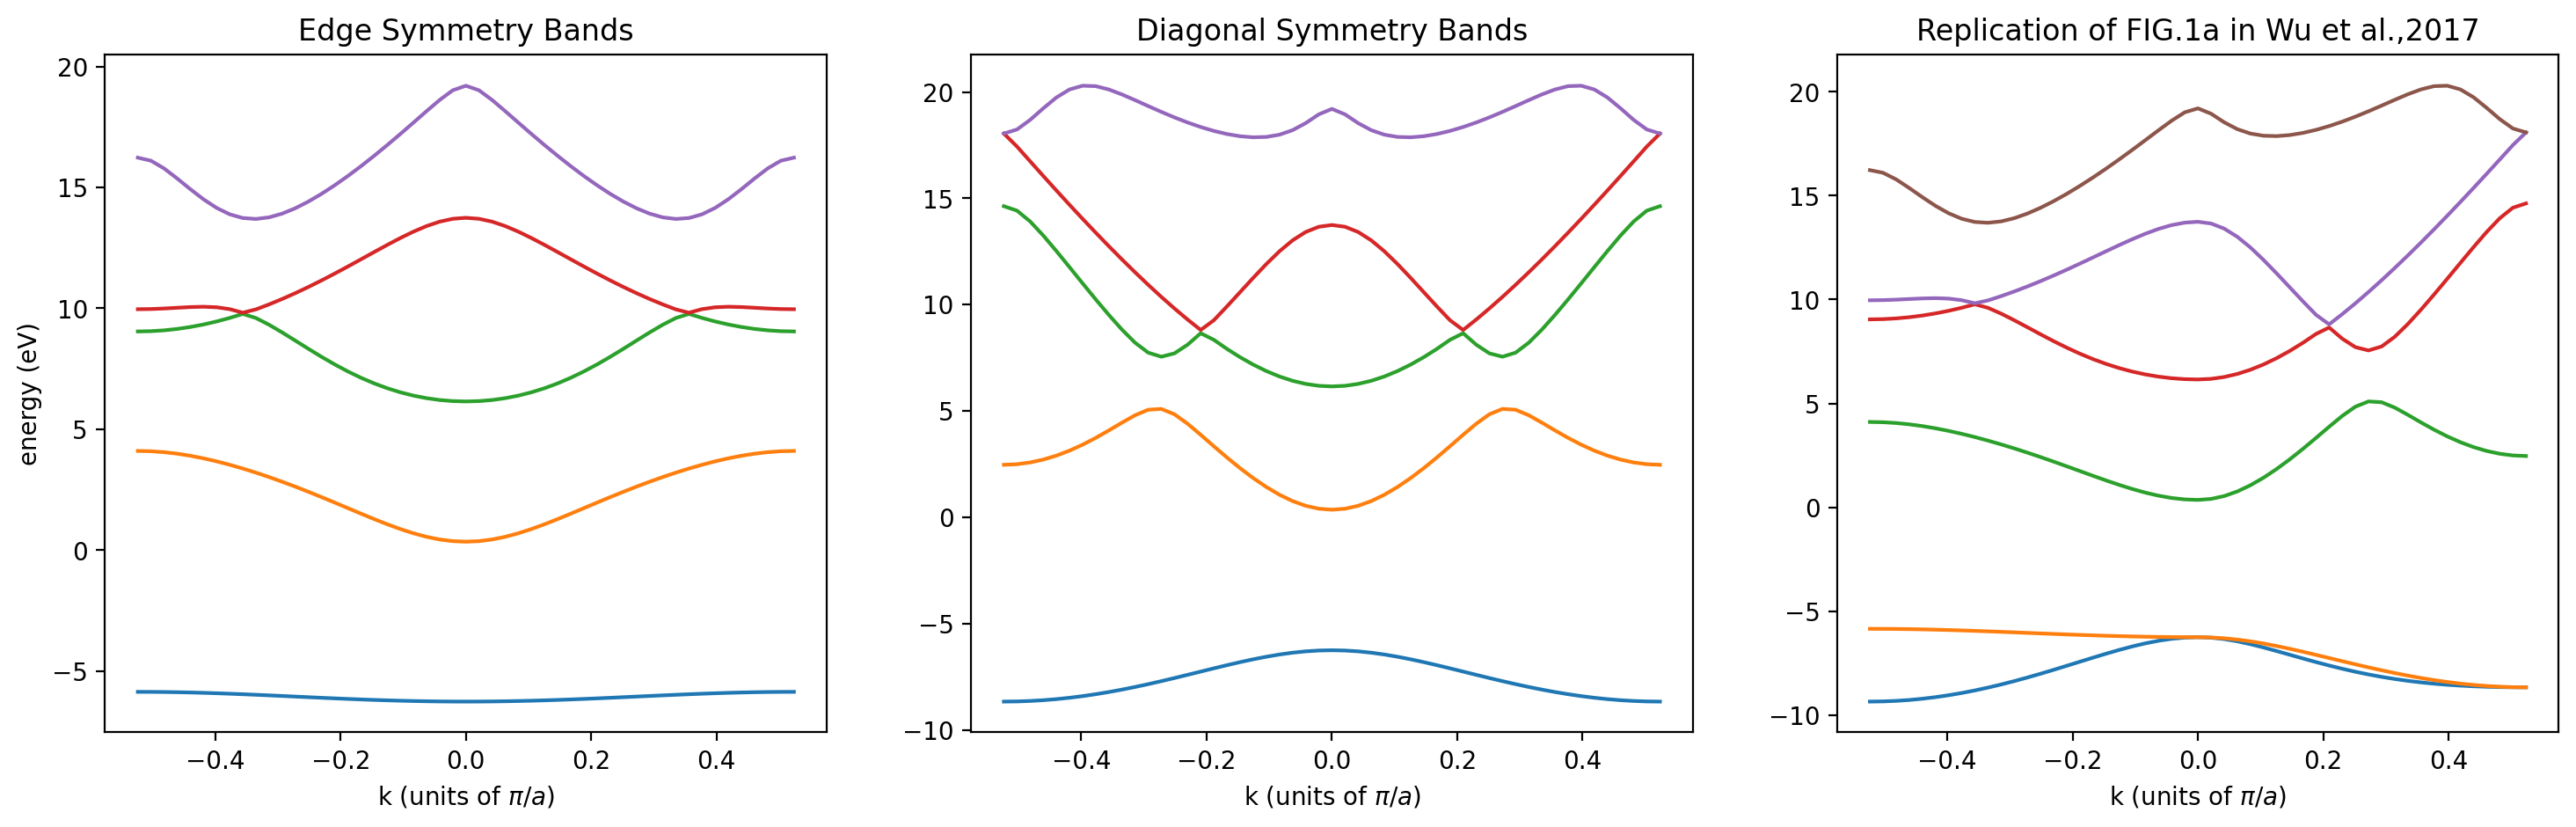

In [28]:
# E_eV ~ [kx index, ky index, E level]

plt.figure(figsize=(18,5))

plt.subplot(131)
plt.title('Edge Symmetry Bands')
plt.xlabel(r'k (units of $\pi/a$)')
plt.ylabel('energy (eV)')
# grab edge energies
edges = E_eV[:,len(E)//2]
plt.plot(K,edges[:,2:7])

plt.subplot(132)
plt.title('Diagonal Symmetry Bands')
plt.xlabel(r'k (units of $\pi/a$)')
# grab diagonal energies
diags = np.array([E_eV[r,r] for r in range(len(K))])
plt.plot(K,diags[:,2:7])

plt.subplot(133)
plt.title('Replication of FIG.1a in Wu et al.,2017')
plt.xlabel(r'k (units of $\pi/a$)')
# put edge energies on first half and diags on second
Esplit = np.array([(edges[r] if r < len(K)//2 else diags[r]) for r in range(len(K))])
plt.plot(K,Esplit[:,1:7]);

### Field Coupling

In order to avoid confusion, from this point on I will denote energies as $\varepsilon$ instead of $E$, which will now instead represent electric fields.

We have solved $\pmb{\mathcal{H}}\psi=\varepsilon\psi$ for a single electron in a periodic potential. This led us to the central equation.

Now, consider the same scenario with a coupling to an electric field. We will use only the vector potential in order to maintain translation invariance (EXPAND), so we are left with $\mathbf{E}=-\frac{\partial}{\partial t}\mathbf{A}(\mathbf{r},t)$.

Generally, we can express a vector potential as $\mathbf{A}(\mathbf{r},t)\equiv\mathbf{A}_0e^{i(\mathbf{k}\cdot\mathbf{r}-wt)}+\mathbf{A}_0^*e^{-i(\mathbf{k}\cdot\mathbf{r}-wt)}$ with $\mathbf{A}_0\equiv A_0\mathbf{n}$ and a spatial period $\lambda=2\pi/|\mathbf{k}|$. We will make an assumption that the wavelength of the $\varepsilon$-field is much larger than the size of the electron (i.e., the dipole-approximation) so that $\lambda\rightarrow\infty$. This implies $|\mathbf{k}|\rightarrow 0$, and thus $\mathbf{A}(\mathbf{r},t)\approx\mathbf{A}(t)$.

We are now tasked with finding the Hamiltonian of our system. Consider the Lorentz force $\mathbf{F}=q(\mathbf{E}+\mathbf{v}\times\mathbf{B})$. Since $\mathbf{A}$ is independent of position, we can express it as
$$
\mathbf{F} = -q\frac{\partial\mathbf{A}}{\partial t} + q\mathbf{v}\times(\mathbf{\nabla}\times\mathbf{A}) = -q\frac{\partial\mathbf{A}}{\partial t}
$$

We can equate this to the expression for a generalized force and solve for $U$:
$$
\mathbf{F} = \frac{d}{dt}\frac{\partial U}{\partial v} = -q\frac{\partial\mathbf{A}}{\partial t}
$$

Since $A$ depends only on $t$, we can say $\frac{\partial A}{\partial t} = \frac{dA}{dt}$ and thus
$$
\frac{\partial U}{\partial v}=-q\mathbf{A} \ \ \ \implies \ \ \ U=-q\mathbf{v}\cdot\mathbf{A}
$$

Inserting this into the Lagrangian allows us to calculate the canonical momentum:
$$
\begin{align}
\mathbf{p} &= \frac{\partial\mathcal{L}}{\partial v} \\
&= \frac{\partial}{\partial v}\left(\frac{1}{2}mv^2 + q\mathbf{v}\cdot\mathbf{A}\right) \\
&= mv+q\mathbf{A}
\end{align}
$$

Which can be used in calculating the Hamiltonian, which gives
$$
\begin{align}
\pmb{\mathcal{H}} &= \frac{\partial\mathcal{L}}{\partial v}\cdot\mathbf{v} - \mathcal{L} \\
&= mv^2 + q\mathbf{A}\cdot\mathbf{v} - \frac{1}{2}mv^2 - q\mathbf{v}\cdot{A} \\
&= \frac{1}{2}mv^2 \\
&= \frac{(\mathbf{p}-q\mathbf{A})^2}{2m}
\end{align}
$$

Finally, adding our periodic potential (and using $q=-e$) gives the Hamiltonian of our system
$$
\begin{align}
\pmb{\mathcal{H}} &= \frac{(\mathbf{p} + e\mathbf{A}(t))^2}{2m} + V(\mathbf{r}) \\
&= \frac{\mathbf{p}^2 + e\mathbf{p}\cdot\mathbf{A}(t) + e\mathbf{A}(t)\cdot\mathbf{p} + e^2|\mathbf{A}(t)|^2}{2m} + V(\mathbf{r}) \\
\end{align}
$$
$$
\boxed{\pmb{\mathcal{H}} = \frac{e^2A^2}{2m} + \left[\frac{\mathbf{p}^2}{2m} + V(\mathbf{r})\right] + \frac{e}{m}\mathbf{A}(t)\cdot\mathbf{p}}
$$

Note that the first term $\alpha\equiv e^2A^2/2m$ is constant and $\mathbf{p}\cdot\mathbf{A}=\mathbf{A}\cdot\mathbf{p}$ since $A$ is position-independent. We insert this into the TDSE to get
$$
i\hbar\frac{\partial\Psi_\mathbf{k}}{\partial t} = \left[\alpha + \frac{\mathbf{p}^2}{2m} + V(\mathbf{r})\right]\Psi_\mathbf{k} + \frac{e}{m}\mathbf{A}\cdot\mathbf{p}\Psi_\mathbf{k}
$$

Now we can write $\Psi_\mathbf{k}$ as a superposition of time-dependent coefficients $C_{n\mathbf{k}}(t)$ and Bloch states $\phi_\mathbf{k}^n(\mathbf{r})=\sum_\mathbf{G}\psi_\mathbf{G}^ne^{i(\mathbf{k}+\mathbf{G})\cdot \mathbf{r}}$
$$
i\hbar\sum_{n'}\dot{C}_{n'\mathbf{k}}(t)\phi_{\mathbf{k}}^{n'}(\mathbf{r}) = \left[\alpha + \frac{\mathbf{p}^2}{2m} + V(\mathbf{r})\right]\sum_{n'}C_{n'\mathbf{k}}(t)\phi_{\mathbf{k}}^{n'}(\mathbf{r}) + \frac{e}{m}\mathbf{A}(t)\cdot\sum_{n'}\mathbf{p}C_{n'k}(t)\phi_\mathbf{k}^{n'}(\mathbf{r})
$$

For which we can now project a state $\phi_\mathbf{k}^n$ onto:
$$
\begin{align}
&i\hbar\sum_{n'}\dot{C}_{n'\mathbf{k}}(t)\int d\mathbf{r} \ \phi_\mathbf{k}^{*n}(\mathbf{r})\phi_\mathbf{k}^{n'}(\mathbf{r}) = \sum_{n'}C_{n'\mathbf{k}}(t)\int d\mathbf{r} \ \phi_\mathbf{k}^{*n}(\mathbf{r})\left[\alpha + \frac{\mathbf{p}^2}{2m} + V(\mathbf{r})\right]\phi_\mathbf{k}^{n'}(\mathbf{r}) + \frac{e}{m}\mathbf{A}(t)\cdot\sum_{n'}C_{n'\mathbf{k}}(t)\int d\mathbf{r} \ \phi_\mathbf{k}^{*n}(\mathbf{r})\mathbf{p}\phi_\mathbf{k}^{n'}(\mathbf{r}) \\
&i\hbar\sum_{n'}\dot{C}_{n'\mathbf{k}}(t)\delta(n-n') = \sum_{n'}C_{n'\mathbf{k}}(t)\varepsilon_{n'\mathbf{k}}\delta(n-n') + \frac{e}{m}\mathbf{A}(t)\cdot\sum_{n'}C_{n'\mathbf{k}}(t)\frac{1}{V}\int d\mathbf{r} \  \phi_\mathbf{k}^{*n}(\mathbf{r})\mathbf{p}\phi_\mathbf{k}^{n'}(\mathbf{r}) \\
&i\hbar\dot{C}_{n\mathbf{k}}(t) = C_{n\mathbf{k}}(t)\varepsilon_{n\mathbf{k}} + \frac{e}{m}\mathbf{A}(t)\cdot\sum_{n'}C_{n'\mathbf{k}}(t)(\mathbf{p}^{nn'}_\mathbf{k})
\end{align}
$$

Where we define $\mathbf{p}_\mathbf{k}^{nn'}\equiv\frac{1}{V}\int d\mathbf{r} \ \phi_\mathbf{k}^{n}(\mathbf{r}) \ \mathbf{p} \ \phi_\mathbf{k}^{n'}(\mathbf{r})$. Component-wise, with $\mu\in\left\{x,y,z\right\}$, this simplifies to
$$
\begin{align}
\left(\mathbf{p}^{nn'}_\mathbf{k}\right)_\mu &= -\frac{i\hbar}{V}\int d\mathbf{r} \ \phi_\mathbf{k}^{*n}(\mathbf{r})\frac{\partial}{\partial\mu}\phi_\mathbf{k}^{n'}(\mathbf{r}) \\
&= -\frac{i\hbar}{V}\int d\mathbf{r} \  \left(\sum_\mathbf{G}\psi_\mathbf{G}^{*n}e^{-i(\mathbf{k}+\mathbf{G})\cdot\mathbf{r})}\right)\frac{\partial}{\partial\mu}\left(\sum_\mathbf{G'}\psi_\mathbf{G'}^{n'}e^{i(\mathbf{k}+\mathbf{G}')\cdot\mathbf{r}}\right) \\
&= -\frac{i\hbar}{V}\sum_{\mathbf{G},\mathbf{G}'}\int d\mathbf{r} \ \psi_\mathbf{G}^{*n}e^{-i(\mathbf{k}+\mathbf{G})\cdot\mathbf{r}}\ i\left(k_\mu+G'_\mu\right)\psi_{\mathbf{G}'}^{n'}e^{i(\mathbf{k}+\mathbf{G}')\cdot\mathbf{r}} \\
&= \frac{\hbar}{V}\sum_{\mathbf{G},\mathbf{G}'}\int d\mathbf{r} \ \psi_\mathbf{G}^{*n}\psi_{\mathbf{G}'}^{n'}e^{i(\mathbf{G}'-\mathbf{G})\cdot\mathbf{r}}\left(k_\mu + G'_\mu\right) \\
&= \frac{\hbar}{V}\sum_{\mathbf{G},\mathbf{G}'}\psi_\mathbf{G}^{*n}\psi_{\mathbf{G}'}^{n'}\left(k_\mu+G'_\mu\right)\delta(\mathbf{G}'-\mathbf{G})V \\
&= \hbar\sum_\mathbf{G}\psi_\mathbf{G}^{*n}\psi_\mathbf{G}^{n'}\left(k_\mu+G_\mu\right)
\end{align}
$$

So therefore our TDSE is
$$
\boxed{i\hbar\dot{C}_{n\mathbf{k}}(t) = C_{n\mathbf{k}}(t)\varepsilon_{n\mathbf{k}} + \frac{e}{m}\sum_\mu A_\mu(t) \sum_{n'}C_{n'\mathbf{k}}(t)\left(\mathbf{p}_\mathbf{k}^{nn'}\right)_\mu}
$$

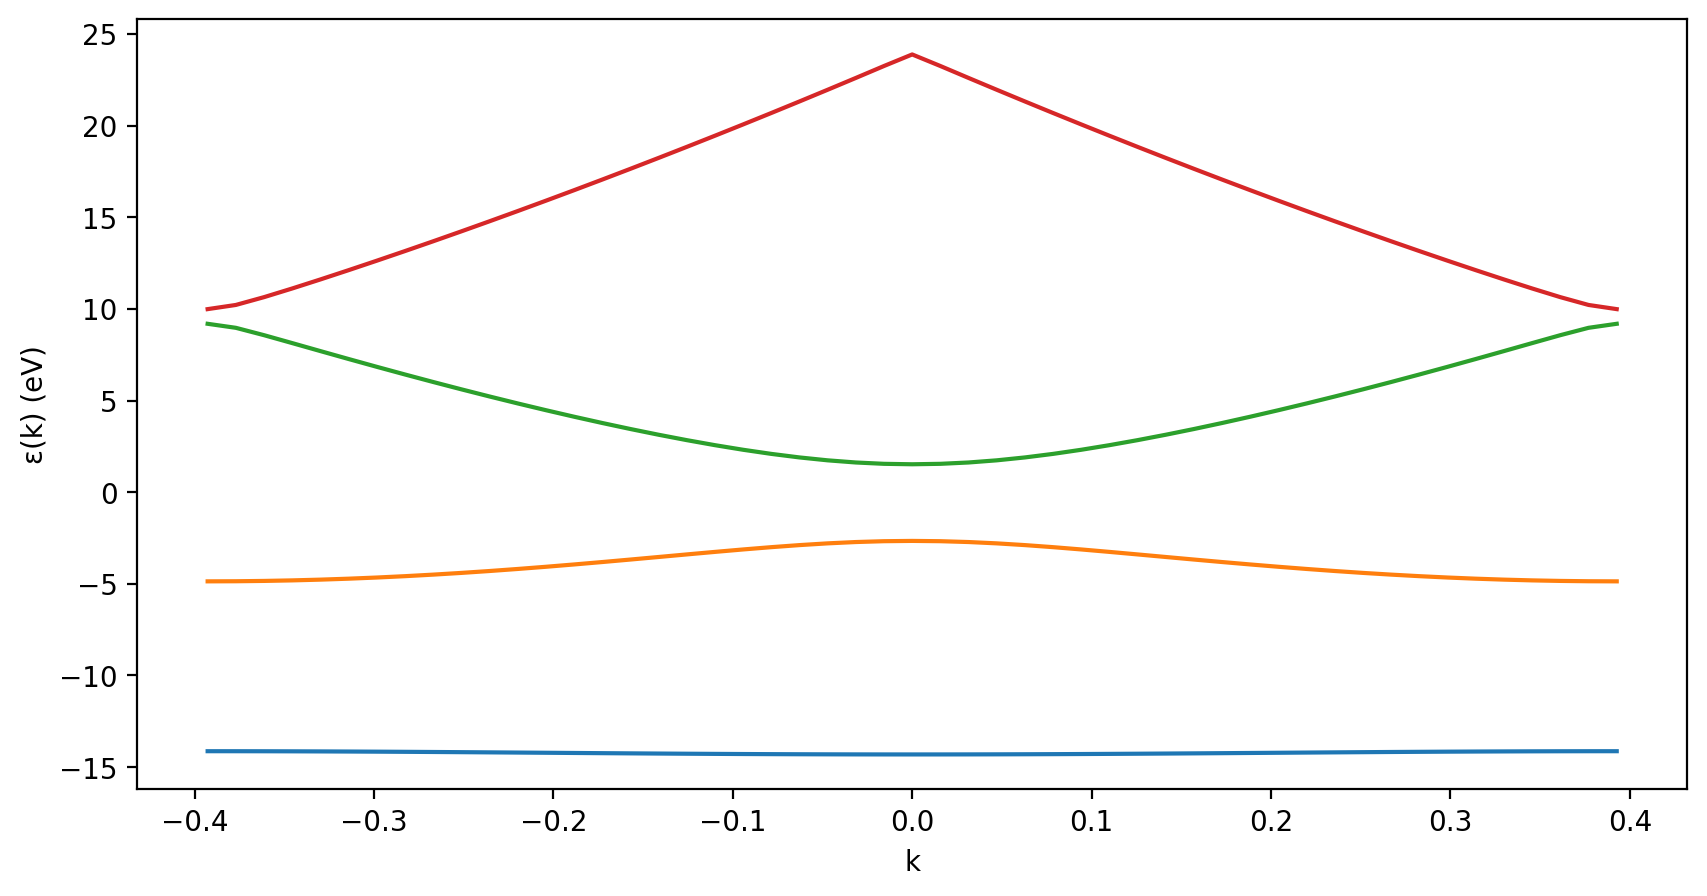

In [29]:
a = 8
N = 50
K = np.linspace(-1,1,N+1) * π/a
nc = 25 # for 51 Bloch states (2*25 + 1)
ε,Ψ = solve_tise(K,nc,V_Wu,a=a)

plt.figure(figsize=(10,5))
plt.xlabel('k')
plt.ylabel('ε(k) (eV)')
plt.plot(K,AU_TO_EV*ε[:,:4]);

#### Constructing $\mathbf{p}_\mathbf{k}^{nn'}$

In [30]:
def construct_p(ik,      # index of k value to use
                K,       # array of k values
                ψ,       # wave functions (ndarray)
                a,       # lattice spacing
                ħ=1):
    k = K[ik]             # k to construct matrix at
    nc = ψ.shape[1] // 2  # G-vector bound used to calculate ε-energies/vectors
    Gs = np.arange(-nc,nc+1) * 2*π/a

    ψ_nm = np.tensordot(np.conj(ψ[ik]), ψ[ik], axes=0)
    p = ħ * np.einsum('ijik,i->jk', ψ_nm, (k-Gs), dtype=complex)
    
    return p

In [31]:
@ipywidgets.interact(ik=(0,N))
def disp(ik=0):
    plt.figure(figsize=(5,5))
    p = construct_p(ik,K,Ψ,a)
    plt.imshow(np.abs(p),vmax=0.1)
    plt.colorbar()
    return ik, f'k= {K[ik]/π*a}π/a'

interactive(children=(IntSlider(value=0, description='ik', max=50), Output()), _dom_classes=('widget-interact'…

In [32]:
pk = np.empty((len(K),2*nc+1,2*nc+1),dtype=complex)
for ik,k in enumerate(K):
    pk[ik] = construct_p(ik,K,Ψ,a)

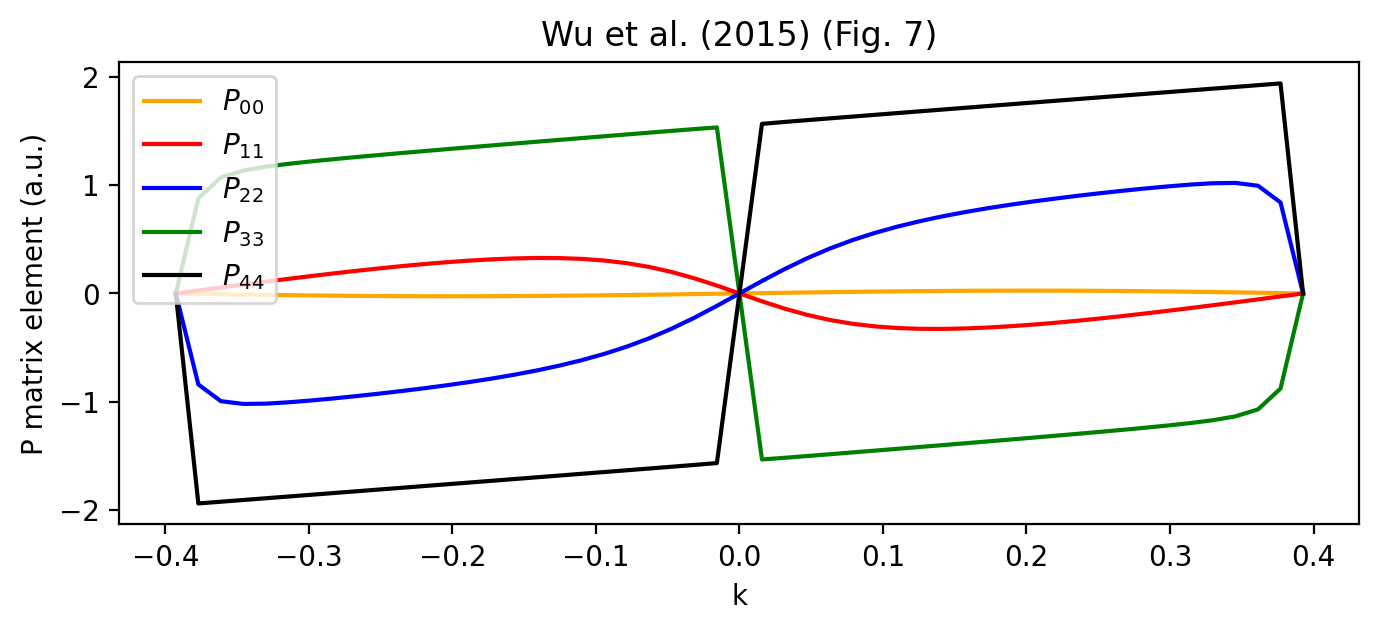

In [33]:
colors = ['orange', 'red', 'blue', 'green', 'black']
plt.title('Wu et al. (2015) (Fig. 7)')
plt.xlabel('k')
plt.ylabel('P matrix element (a.u.)')
for i in range(5):
    plt.plot(K,np.real(pk[:,i,i]),color=colors[i],label=rf'$P_{{{i}{i}}}$')
plt.legend();

#### Constructing $\mathbf{A}$

In [34]:
t0,t1 = 0,50
δt = 5e-3
T = np.linspace(t0,t1,int((t1-t0)/δt))

def E_env(t,ω=100,E0=1,ω0=1):
    return E0 * np.cos(ω*t)**4 * np.cos(ω0*t)

def A_env_exact(t,ω=100,E0=1,ω0=1):
    return -0.25*E0 * (0.25*(np.sin((4*ω-ω0)*t)/(4*ω-ω0) + np.sin((4*ω+ω0)*t)/(4*ω+ω0)) + np.sin((2*ω-ω0)*t)/(2*ω-ω0) + np.sin((2*ω+ω0)*t)/(2*ω+ω0) + 3*np.sin(ω0*t)/2/ω0)

# construct A over timespan T
def construct_A(T,E):
    return -integrate.cumulative_simpson(E(T), x=T, initial=0)

# compute A from 0 to time t
def compute_A(t,T,E):
    if t < T[0] or t > T[-1]:
        print(r'Warning: specified time not in given timespan.')
    it = np.abs(T-t).argmin() + 1 # find index of value closest to t in T
    T = T[:it]
    return -integrate.simpson(E(T),x=T)

A_sp = construct_A(T,E_env)
A_ex = A_env_exact(T)

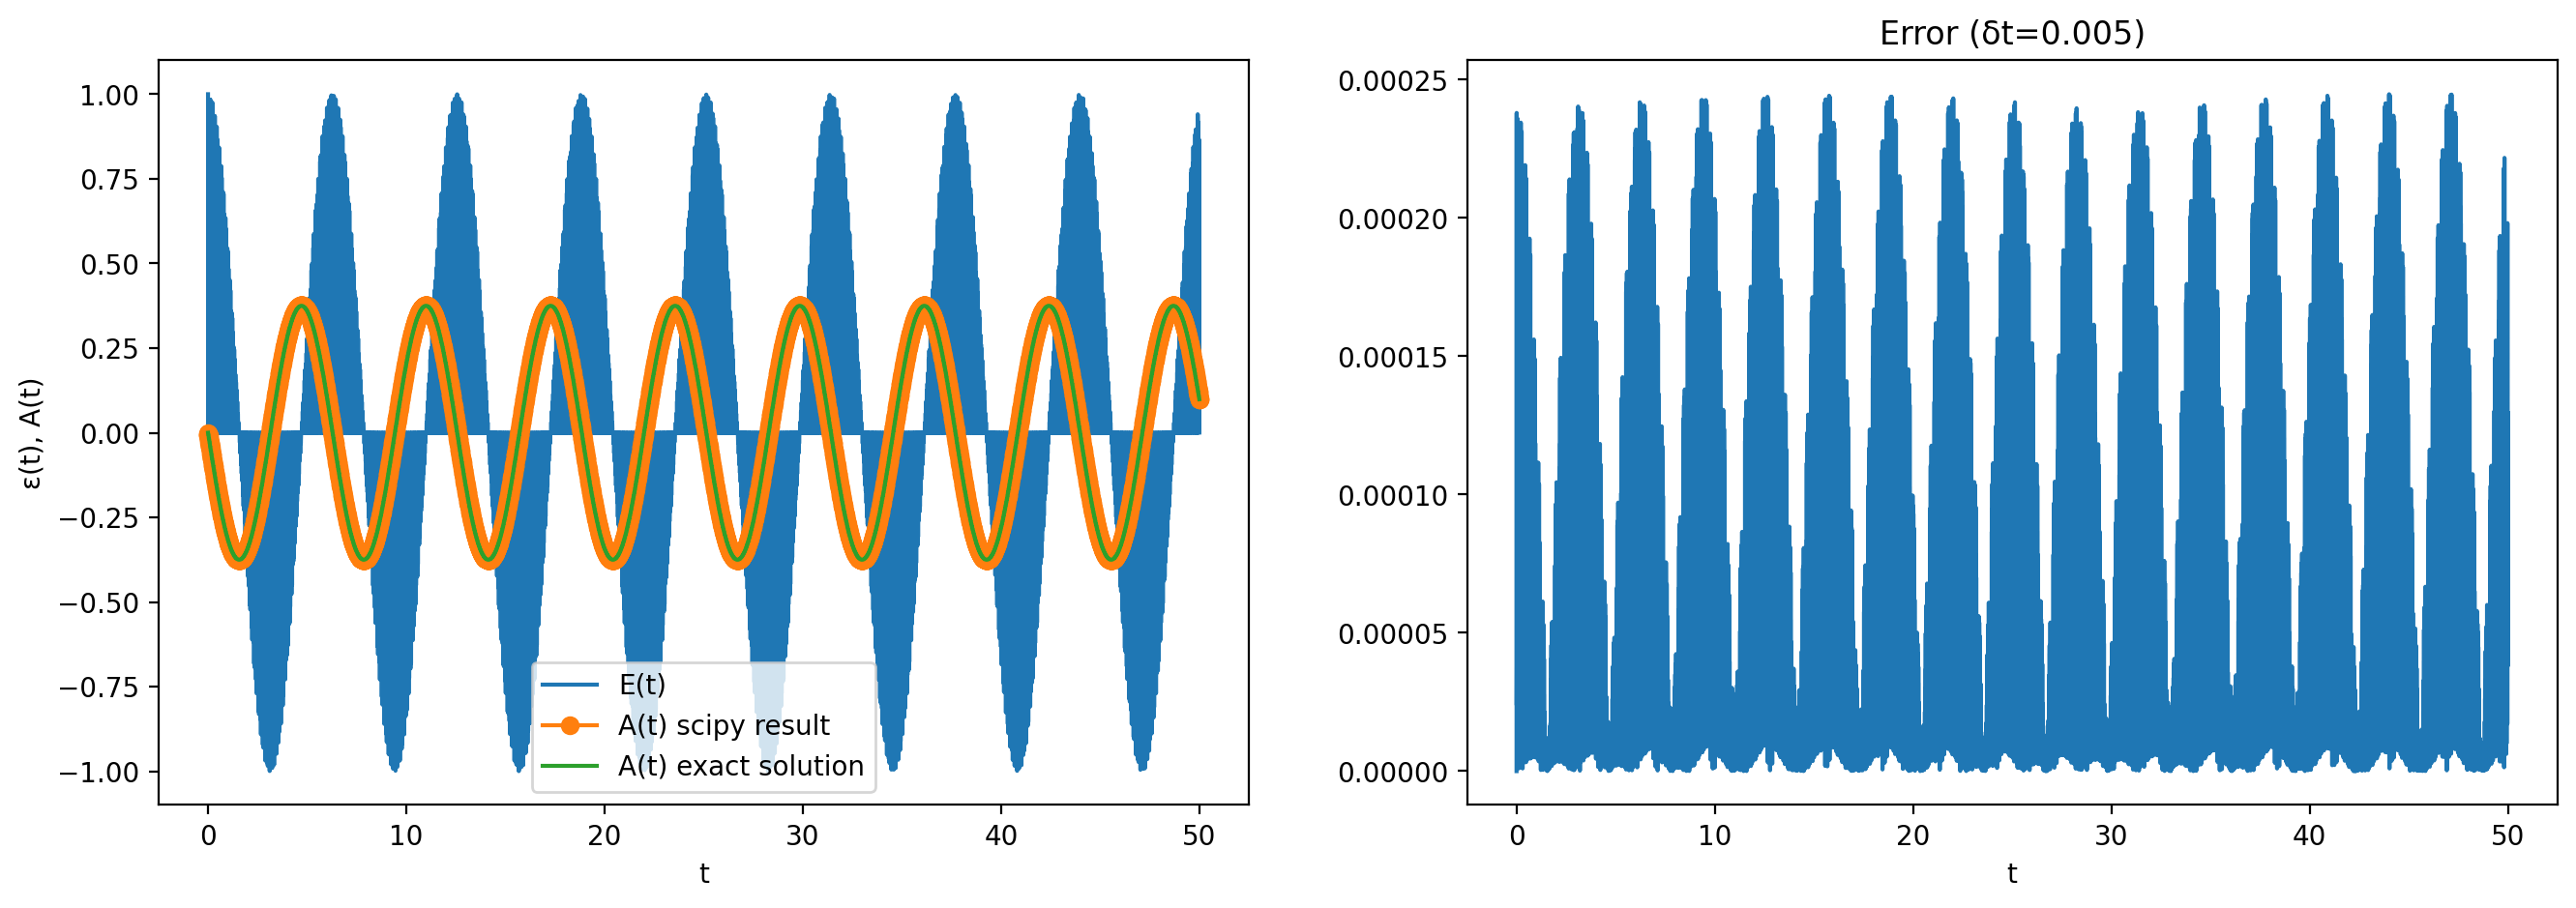

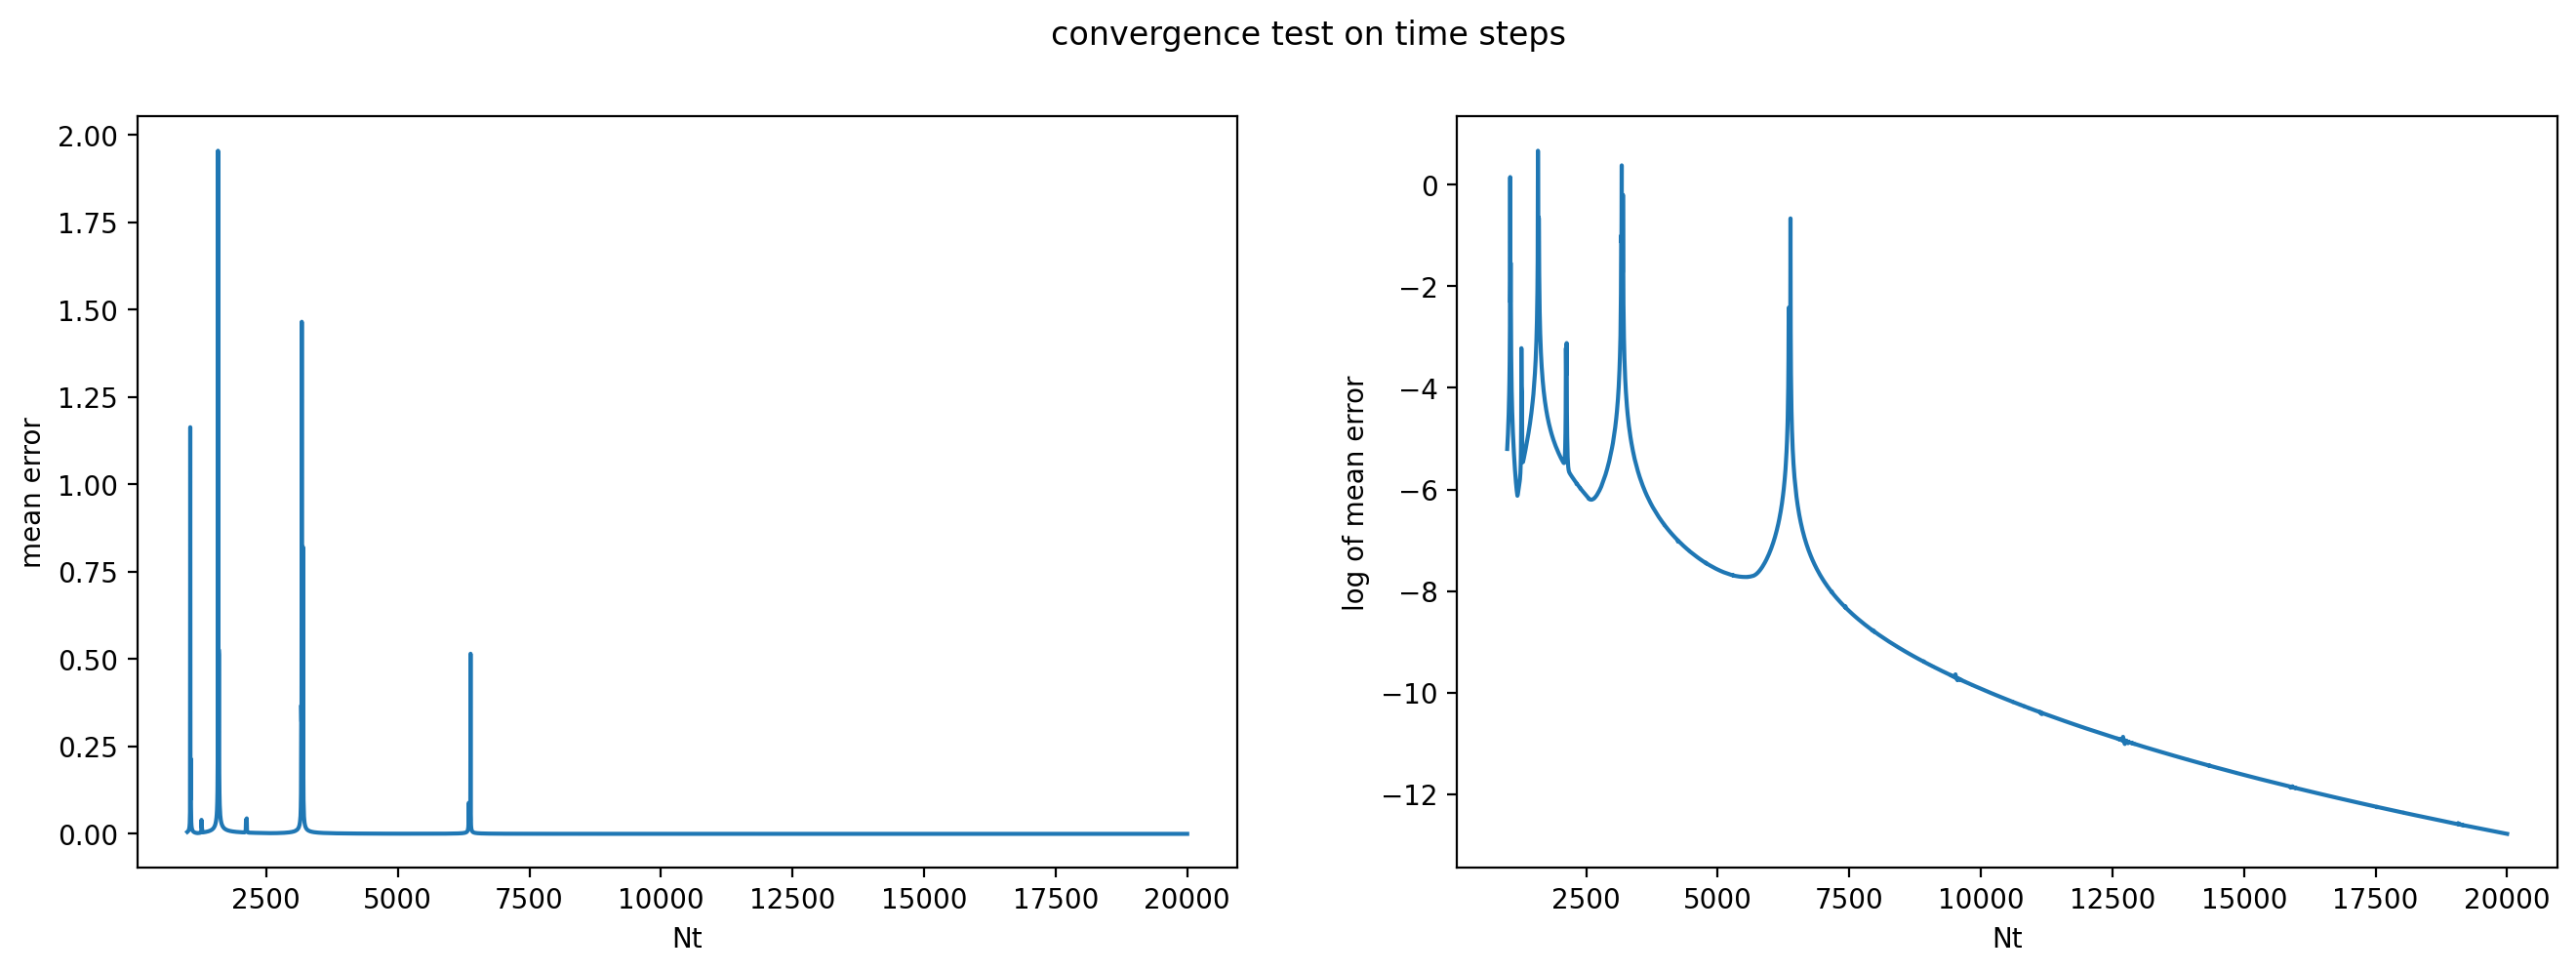

In [35]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.xlabel('t')
plt.ylabel('ε(t), A(t)')
plt.plot(T,E_env(T),label='E(t)');
plt.plot(T,A_sp,marker='o',label='A(t) scipy result')
plt.plot(T,A_ex,label='A(t) exact solution')
plt.legend();

plt.subplot(1,2,2)
plt.xlabel('t')
plt.title(f'Error (δt={δt})')
plt.plot(T,np.abs(A_sp - A_ex));

Nts = np.linspace(1000,20000,4000,dtype=int)
errors = np.empty_like(Nts,dtype=float)
for iN,N in enumerate(Nts):
    Ti = np.linspace(t0,t1,N)
    A_spi = construct_A(Ti,E_env)
    A_exi = A_env_exact(Ti)
    δA = np.mean(np.abs(A_spi - A_exi))
    errors[iN] = δA
plt.figure(figsize=(16,5)).suptitle('convergence test on time steps')
# plt.title('convergence test on # of time steps')
plt.subplot(1,2,1)
plt.xlabel('Nt')
plt.ylabel('mean error')
plt.plot(Nts,errors);
plt.subplot(1,2,2)
plt.xlabel('Nt')
plt.ylabel('log of mean error')
plt.plot(Nts,np.log(errors));

In [36]:
errmax = errors[errors > 0.25][-1]
print(f'last error spike (near Nt=6500) is {errmax}')
iErr = np.abs(errors - errmax).argmin()
print(f'corresponding index is {iErr}')
print(f'So thus we require Nt > {Nts[iErr]} or δt < {(t1-t0)/Nts[iErr]}')

last error spike (near Nt=6500) is 0.5154026830509014
corresponding index is 1133
So thus we require Nt > 6383 or δt < 0.007833307222309259


In [37]:
δt = 0.005

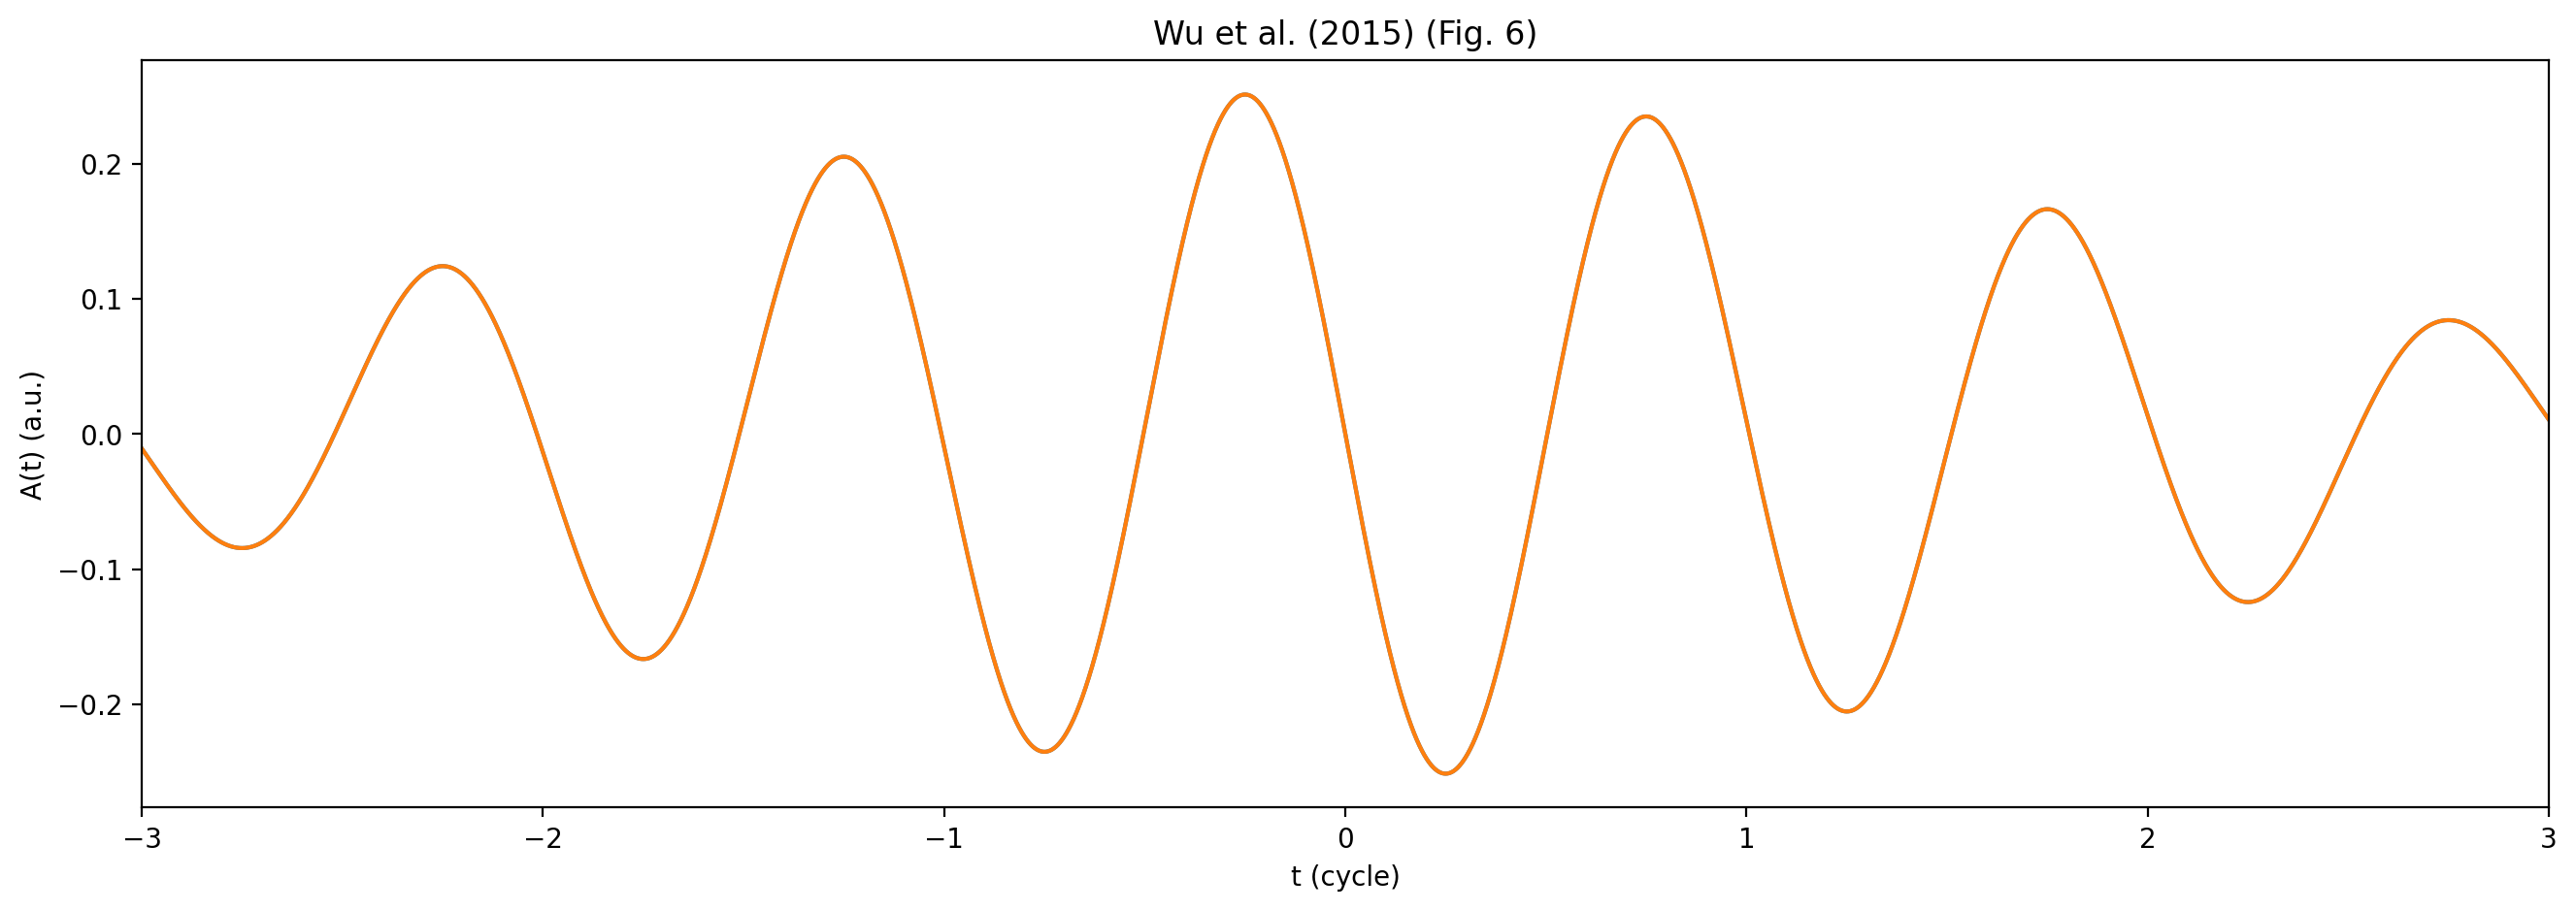

In [38]:
E0_Wu = 3.58085e-3 # From I=(1/2)cϵₒEₒ^2
ω_Wu  = 5.80000e-4 # From G(t)
ω0_Wu = 2*π*2.26616e-3 # From 3.2μm laser wavelength and f=c/λ

def E_Wu(t,ω=ω_Wu,E0=E0_Wu,ω0=ω0_Wu):
    return E0 * np.cos(ω*t)**4 * np.cos(ω0*t)

import numpy as np

@numba.njit
def A_Wu0(x, ω0=ω0_Wu, ω=ω_Wu,E0=E0_Wu):
    term1 = (6 * np.sin(x * ω0)) / ω0
    term2 = np.sin(x * (ω0 - 4 * ω)) / (ω0 - 4 * ω)
    term3 = (4 * np.sin(x * (ω0 - 2 * ω))) / (ω0 - 2 * ω)
    term4 = (6 * np.sin((π * ω0) / (2 * ω))) / ω0
    term5 = np.sin((π * ω0) / (2 * ω)) / (ω0 - 4 * ω)
    term6 = -(4 * np.sin((π * ω0) / (2 * ω))) / (ω0 - 2 * ω)
    term7 = -(4 * np.sin((π * ω0) / (2 * ω))) / (ω0 + 2 * ω)
    term8 = np.sin((π * ω0) / (2 * ω)) / (ω0 + 4 * ω)
    term9 = (4 * np.sin(x * (ω0 + 2 * ω))) / (ω0 + 2 * ω)
    term10 = np.sin(x * (ω0 + 4 * ω)) / (ω0 + 4 * ω)
    return -(E0/16) * (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10)

t0,t1 = -π/2/ω_Wu, π/2/ω_Wu
T = np.arange(t0,t1+δt,δt)

from scipy import interpolate
A_Wu = construct_A(T,E_Wu)
A_fcn = interpolate.interp1d(T,A_Wu)

plt.figure(figsize=(16,5))

plt.xlim(-3,3)
plt.title('Wu et al. (2015) (Fig. 6)')
plt.xlabel('t (cycle)')
plt.ylabel('A(t) (a.u.)')
plt.plot(T*ω0_Wu/2/π,A_fcn(T),label='A(t)');
plt.plot(T*ω0_Wu/2/π,A_Wu0(T),label='A(t), analytic');

In one dimension we have
$$
i\hbar\dot{C}_{n\mathbf{k}}(t) = C_{n\mathbf{k}}(t)\varepsilon_{n\mathbf{k}} + \frac{e}{m}A(t) \sum_{n'}C_{n'\mathbf{k}}(t)\left(\mathbf{p}_\mathbf{k}^{nn'}\right)
$$

In [39]:
@numba.njit
def tdse(ti,C,ε_nk,p,e,m):
    return -1.0j*(C*ε_nk + e/m*A_Wu0(ti) * C@p)
    
def solve_tdse(t,δt,     # time range and time step
               C0,       # initial values of C, i.e., C_nk(t0)
               K,ik,     # K grid and index of k to use
               ε,Ψ,      # energies and wavefcns from tise
               a,        # lattice spacing
               e=1,m=1):
    t0,t1 = (t[0],t[1]) if isinstance(t,list) else (0,t)
    p = construct_p(ik,K,Ψ,a)
    ε_nk=ε[ik,:]
    T = np.arange(t0,t1,δt)
    C0 = np.array(C0, dtype=complex) # required by scipy (initial values must be complex if soln complex) 
    soln = integrate.solve_ivp(tdse, [t0,t1], C0, t_eval=T, args=(ε_nk,p,e,m), method='DOP853',rtol=1e-10, atol=1e-10)
    return soln.t, soln.y

In [40]:
%%time
ik = len(K)//2
print(f'k = {K[ik]*a/π}π/a')
n = 1
C0 = np.zeros(Ψ.shape[1])
C0[n] = 1

T,C = solve_tdse([t0,t1],δt,C0,K,ik,ε,Ψ,a)

k = 0.0π/a
CPU times: user 22.8 s, sys: 790 ms, total: 23.6 s
Wall time: 22 s


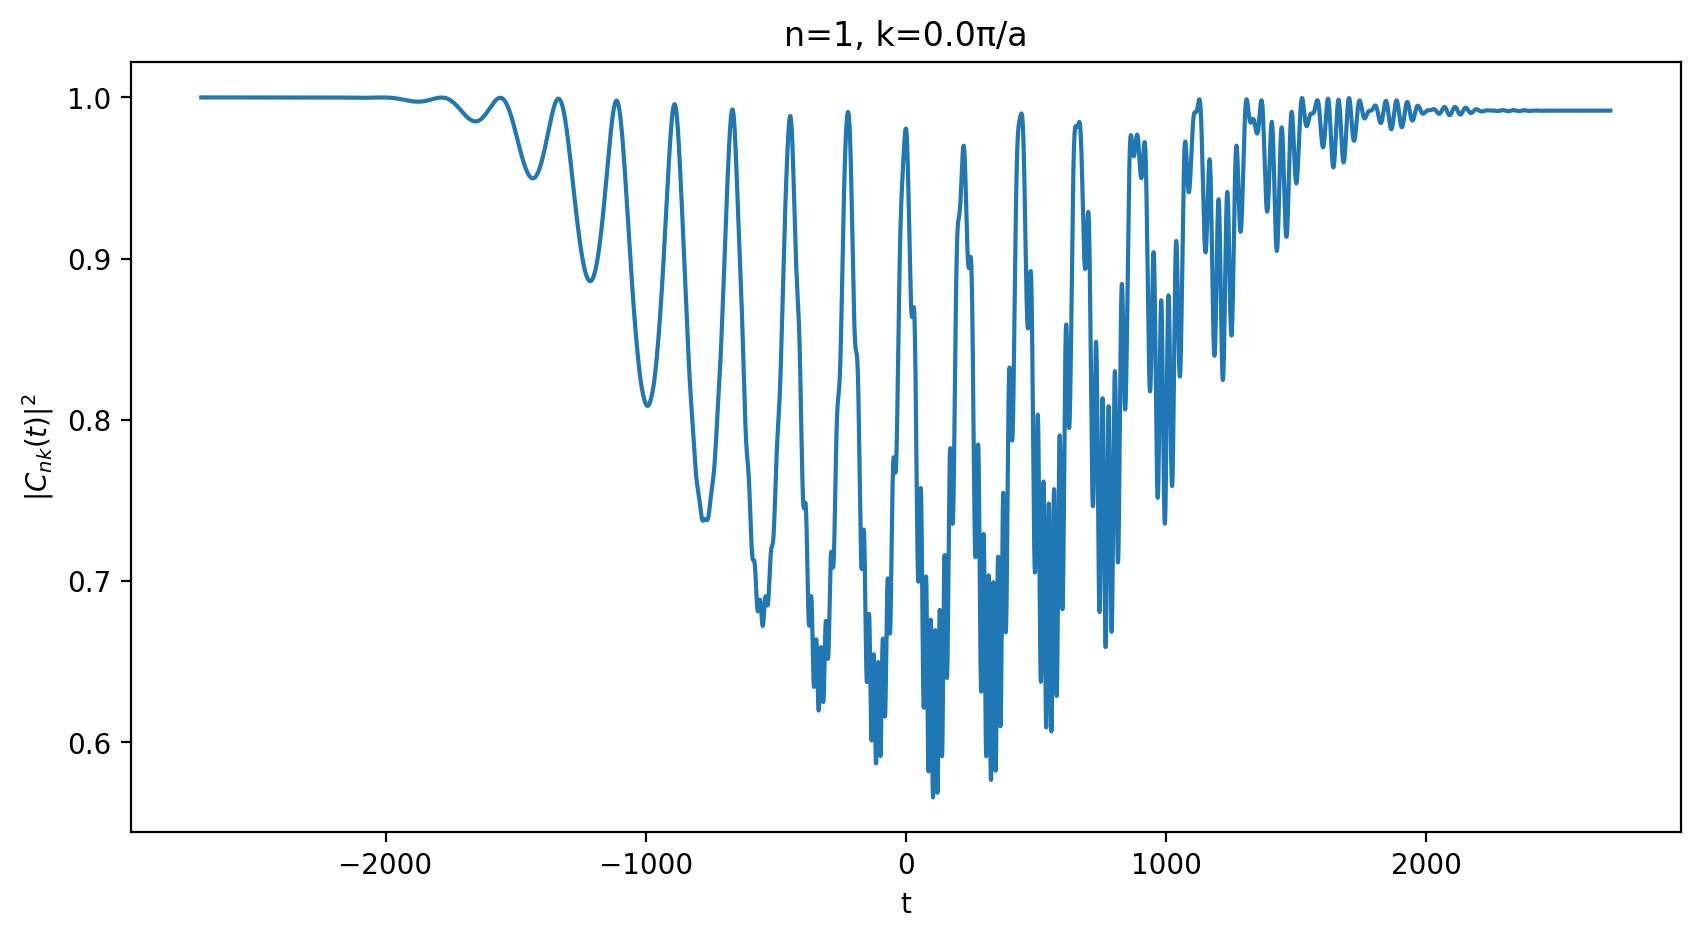

In [41]:
plt.figure(figsize=(10,5))
plt.title(f'n={n}, k={K[ik]*a/π}π/a')
plt.xlabel('t')
plt.ylabel(r'$|C_{nk}(t)|^2$')
plt.plot(T,np.abs(C[n])**2);

Now, we can calculate the time-dependent current $j_\mathbf{k}(t)$ for a single momentum channel $\mathbf{k}$
$$
\begin{align}
\left(j_\mathbf{k}(t)\right)_\mu &= -\frac{e}{m}\left[\text{Re}\left(\frac{1}{\text{Vol}}\int_{cell}d^3\mathbf{r} \ \Psi_\mathbf{k}^*(\mathbf{r},t)\frac{\hbar}{i}\frac{\partial}{\partial\mu}\Psi_\mathbf{k}(\mathbf{r},t)\right) + eA_\mu(t)\right] \\
&= -\frac{e}{m}\left[\text{Re}\left(\frac{1}{\text{Vol}}\int_{cell}d^3\mathbf{r} \ \sum_nC_{n\mathbf{k}}^*(t)\phi_\mathbf{k}^{*n}(\mathbf{r})\frac{\hbar}{i}\frac{\partial}{\partial\mu}\sum_{n'}C_{n'\mathbf{k}}(t)\phi_\mathbf{k}^{n'}(\mathbf{r})\right) + eA_\mu(t)\right] \\
&= -\frac{e}{m}\left[\text{Re}\left(\sum_n\sum_{n'}C_{n\mathbf{k}}^*(t)C_{n'\mathbf{k}}(t)\frac{1}{\text{Vol}}\int_{cell}d^3\mathbf{r} \ \phi_\mathbf{k}^{*n}(\mathbf{r})\frac{\hbar}{i}\frac{\partial}{\partial\mu}\phi_\mathbf{k}^{n'}(\mathbf{r})\right) + eA_\mu(t)\right] \\
&= -\frac{e}{m}\left[\text{Re}\left(\sum_n\sum_{n'}C_{n\mathbf{k}}^*(t)C_{n'\mathbf{k}}(t)\left(p_{\mathbf{k}}^{nn'}\right)_\mu\right) + eA_\mu(t)\right]
\end{align}
$$

Which we can use to calculate the high harmonic spectrum, via the fourier transform of the current
$$
I_{\text{HHG}} = \left|\left(j_\mathbf{k}(\omega)\right)_\mu\right|^2
$$

CPU times: user 6.78 s, sys: 304 ms, total: 7.08 s
Wall time: 5.75 s


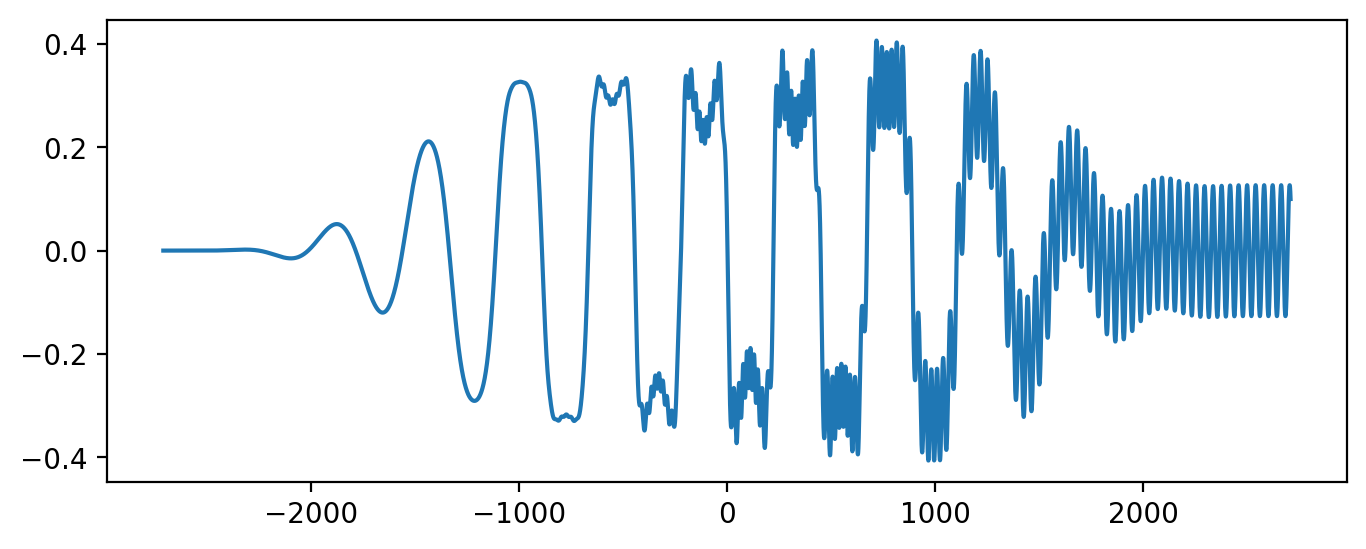

In [42]:
%%time
def construct_j(T,C,K,ik,Ψ,A,a,e=1,m=1):
    p = construct_p(ik,K,Ψ,a)
    ccp = np.einsum('ik,jk,ij->k', np.conj(C), C, p, dtype=complex)
    return -e/m * (np.real(ccp) + e*A(T))

J = construct_j(T,C,K,ik,Ψ,A_Wu0,a)
plt.plot(T,J);

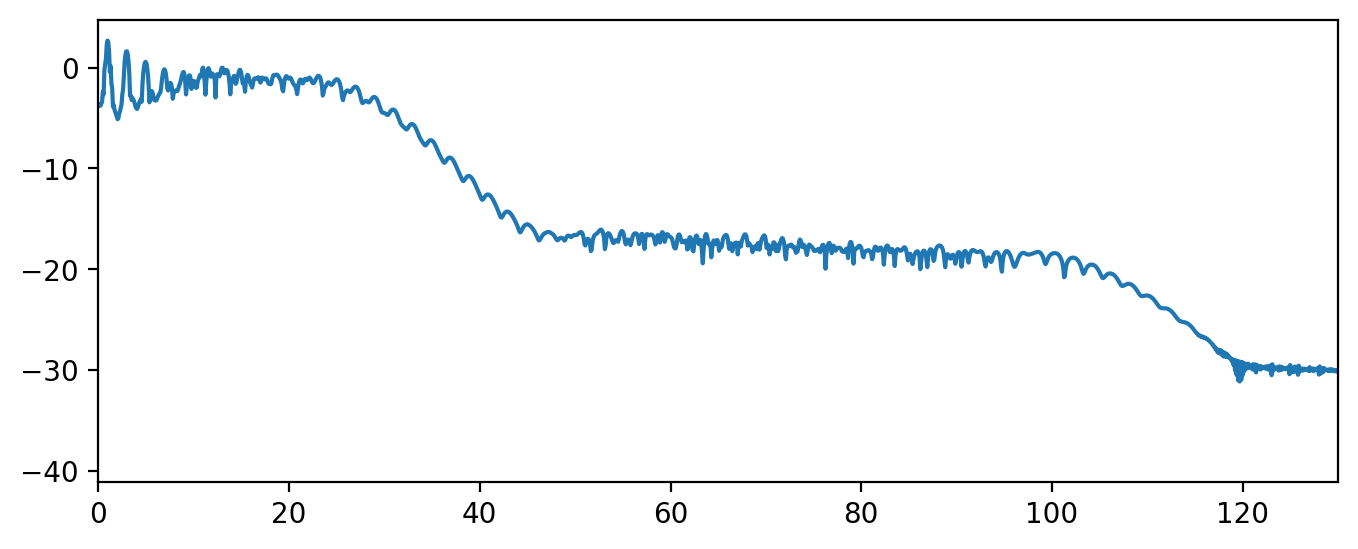

In [43]:
def I_HHG(J,δt):
    Nt = len(J)
    Jω = np.fft.fft(J*np.cos(T*ω_Wu)**4)
    Ω  = np.fft.fftfreq(Nt,d=δt)*2.0*np.pi
    Ω, Jω = Ω[:Nt//2], Jω[:Nt//2]
    return Ω, np.abs( Jω/np.max(Jω) )**2

Ω,I = I_HHG(J,δt)
plt.xlim(0,130)
#plt.ylim(-10,0)
plt.plot(Ω/ω0_Wu, np.log10(I));

### Field Coupling (2D)

In [88]:
a = 6
N = 50
K = np.linspace(-1,1,N+1) * π/a
nc = 5
ε,Ψ = solve_tise2D(K,K,nc,V_Wu2D,a=6)
ε_eV = AU_TO_EV*ε # au to eV

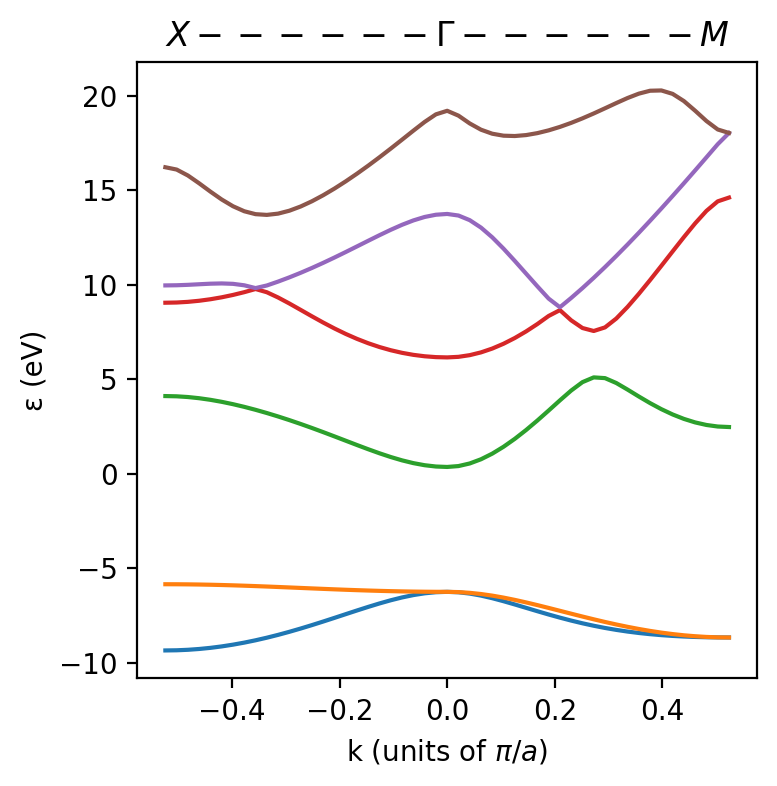

In [89]:
def εXM(ε,joined=False):
    nε = len(ε)
    εX = ε[:,nε//2]
    εM = np.array([ε[r,r] for r in range(len(ε))])
    if joined:
        split = np.array([(εX[i] if i < nε//2 else εM[i]) for i in range(nε)])
        return split
    else:
        return εX,εM

plt.figure(figsize=(4,4))

εX,εM = εXM(ε_eV)

plt.title(r'$X------ \Gamma ------M$')
plt.xlabel(r'k (units of $\pi/a$)')
plt.ylabel('ε (eV)')
ε_split = εXM(ε_eV,True)
plt.plot(K,ε_split[:,1:7]);

Recall for the momentum we are computing
$$
\left(\mathbf{p}^{nn'}_\mathbf{k}\right)_\mu = \hbar\sum_\mathbf{G}\psi_\mathbf{G}^{*n}\psi_\mathbf{G}^{n'}\left(k_\mu+G_\mu\right)
$$

In [125]:
def construct_p2D(ikx,
                  Kx,
                  iky,
                  Ky,
                  ψ,
                  a,
                  ħ=1):
    k = np.array([Kx[ikx], Ky[iky]])
    nE = ψ.shape[2] # number of wave-fcns/energies
    nc = np.sqrt(nE) // 2
    N = int(2*nc+1)
    Gs = np.empty((N**2,2))
    for nx in range(N):
        for ny in range(N):
            i = nx*N + ny
            Gs[i] = np.array([nx-nc, ny-nc]) * 2*π/a

    # p = np.zeros((nE,nE,2), dtype=complex)
    # for n in range(nE):
    #     for m in range(nE):
    #         for iG,G in enumerate(Gs):
    #             p[n,m] += ħ * np.conj(ψ[ikx,iky,iG,n]) * ψ[ikx,iky,iG,m] * (k-G)
    ψ_nm = np.tensordot(np.conj(ψ[ikx,iky]), ψ[ikx,iky], axes=0)
    px = ħ * np.einsum('ijik,i->jk', ψ_nm, (k[0]-Gs[:,0]), dtype=complex)
    py = ħ * np.einsum('ijik,i->jk', ψ_nm, (k[1]-Gs[:,1]), dtype=complex)
    return px,py

In [126]:
ik = 25
p = construct_p2D(ik,K,ik,K,Ψ,a)
p[0].shape

(121, 121)

In [48]:
@ipywidgets.interact(ik=(0,N))
def disp(ik=0):
    plt.figure(figsize=(5,5))
    p = construct_p2D(ik,K,ik,K,Ψ,a)[0]
    plt.imshow(np.abs(p),vmax=0.1)
    plt.colorbar()
    return ik, f'k= {K[ik]/π*a}π/a'

interactive(children=(IntSlider(value=0, description='ik', max=50), Output()), _dom_classes=('widget-interact'…

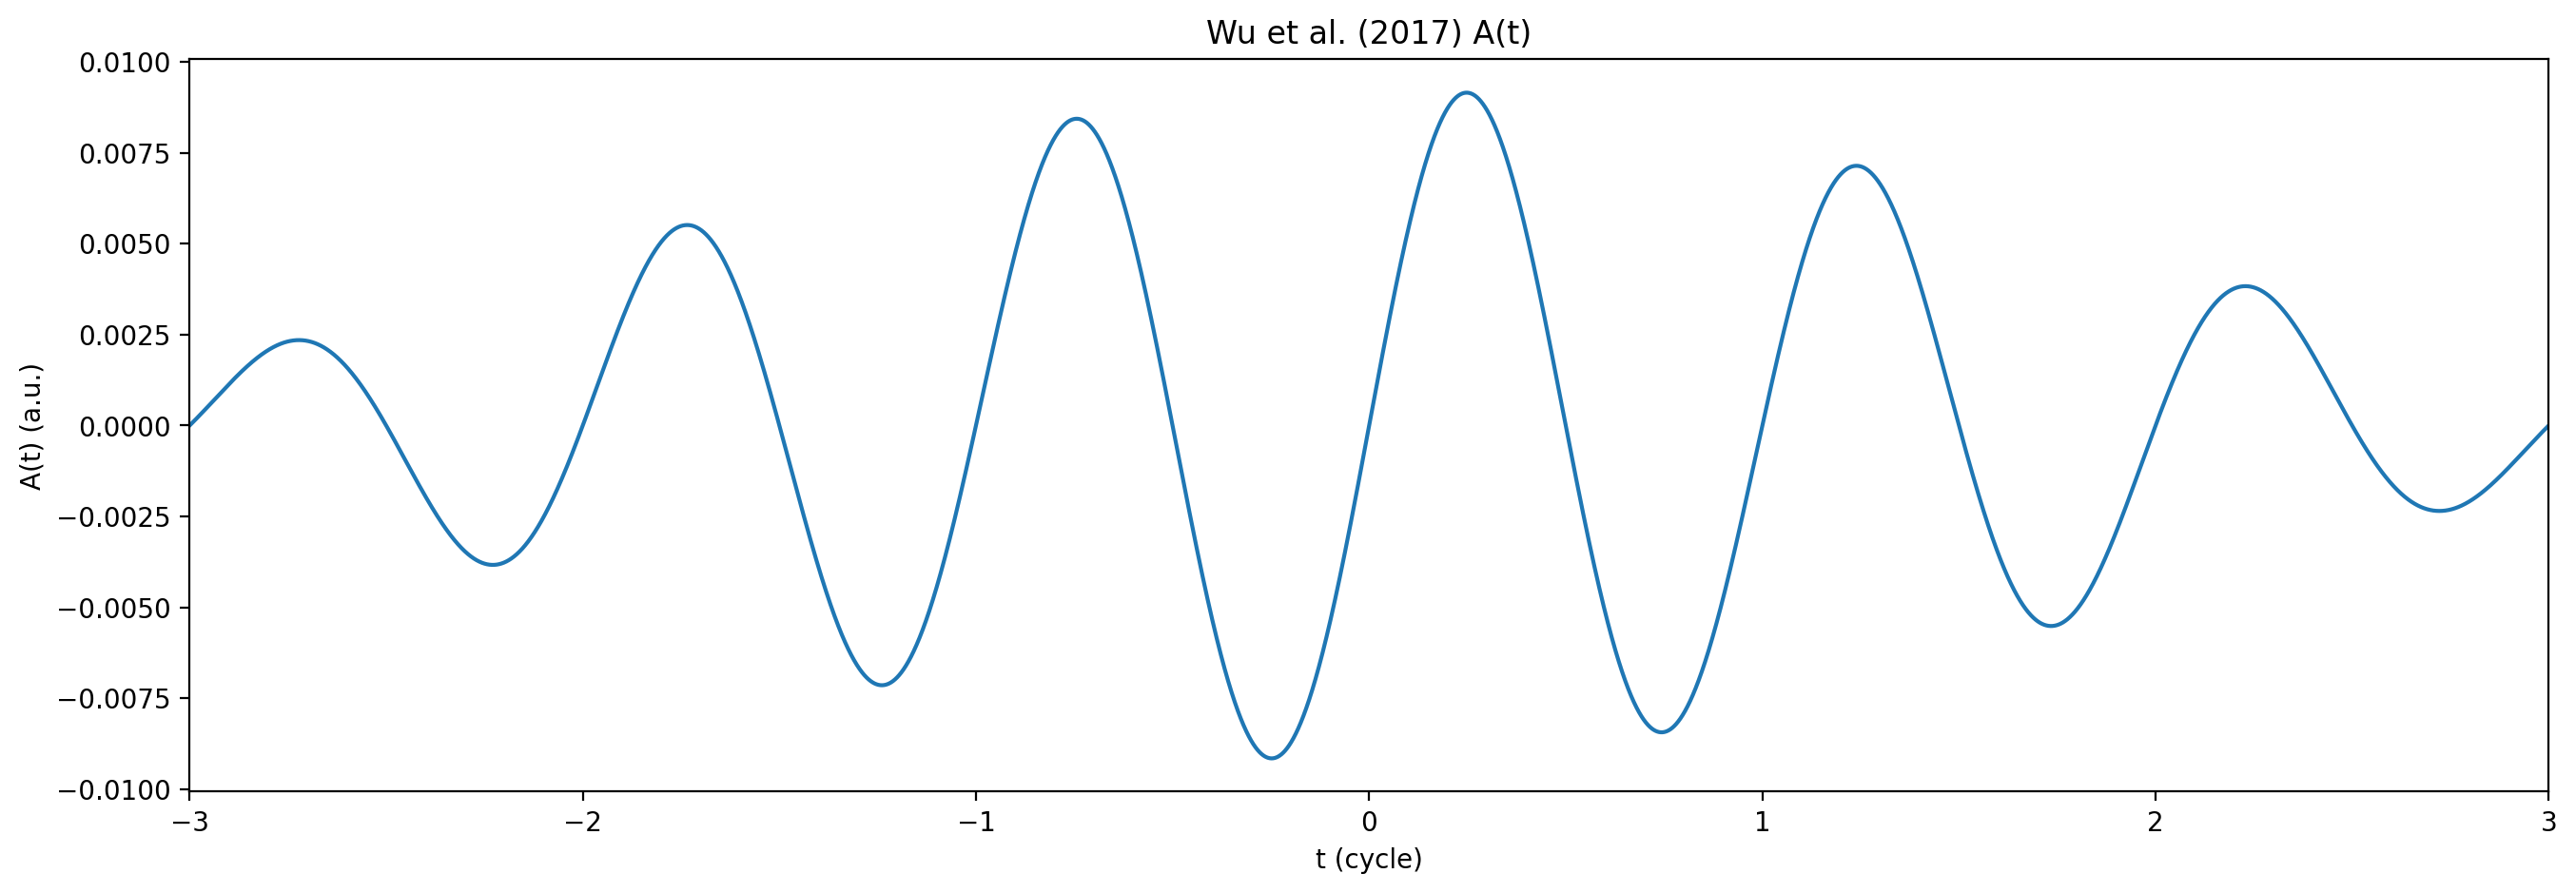

In [49]:
A0_Wu2D = 9.245733e-3    # From I=(1/2)cϵₒEₒ^2
ω0_Wu2D = 2*π*4.53219e-3 # From 1600nm laser wavelength and f=c/λ
ω_Wu2D = ω0_Wu2D / 22

def A_Wu2D(t,ω0=ω0_Wu2D,ω=ω_Wu2D,A0=A0_Wu2D,polarization='X'):
    if polarization.lower() == 'x':
        Ax = A0 * np.cos(ω*t)**4 * np.sin(ω0*t)
        Ay = 0
    return Ax,Ay

t0,t1 = -π/2/ω_Wu, π/2/ω_Wu
T = np.arange(t0,t1+δt,δt)

plt.figure(figsize=(16,5))

plt.xlim(-3,3)
plt.title('Wu et al. (2017) A(t)')
plt.xlabel('t (cycle)')
plt.ylabel('A(t) (a.u.)')
plt.plot(T*ω0_Wu2D/2/π,A_Wu2D(T)[0],label='A(t)');

Recall that the TDSE we are solving is

$$
i\hbar\dot{C}_{n\mathbf{k}}(t) = C_{n\mathbf{k}}(t)\varepsilon_{n\mathbf{k}} + \frac{e}{m}\sum_\mu A_\mu(t) \sum_{n'}C_{n'\mathbf{k}}(t)\left(\mathbf{p}_\mathbf{k}^{nn'}\right)_\mu
$$

In [112]:
#@numba.njit
def tdse2D(ti,C,ε_nk,px,py,e,m):
    Ax,Ay = A_Wu2D(ti)
    return -1.0j*(C*ε_nk + e/m*(Ax*C@px + Ay*C@py))

def solve_tdse2D(t,δt,
                 C0,
                 Kx,ikx,
                 Ky,iky,
                 ε,Ψ,
                 a,
                 e=1,m=1):
    t0,t1 = (t[0],t[1]) if isinstance(t,list) else (0,t)
    px,py = construct_p2D(ikx,Kx,iky,Ky,Ψ,a)
    ε_nk = ε[iky,:]
    ε_nk = np.average(ε, axis=0)
    T = np.arange(t0,t1,δt)
    C0 = np.array(C0, dtype=complex)
    soln = integrate.solve_ivp(tdse2D, [t0,t1], C0, t_eval=T, args=(ε_nk,px,py,e,m), method='DOP853', rtol=1e-10, atol=1e-10)
    return soln.t, soln.y

k = 0.0π/a
CPU times: user 2min 56s, sys: 4.66 s, total: 3min 1s
Wall time: 25.5 s


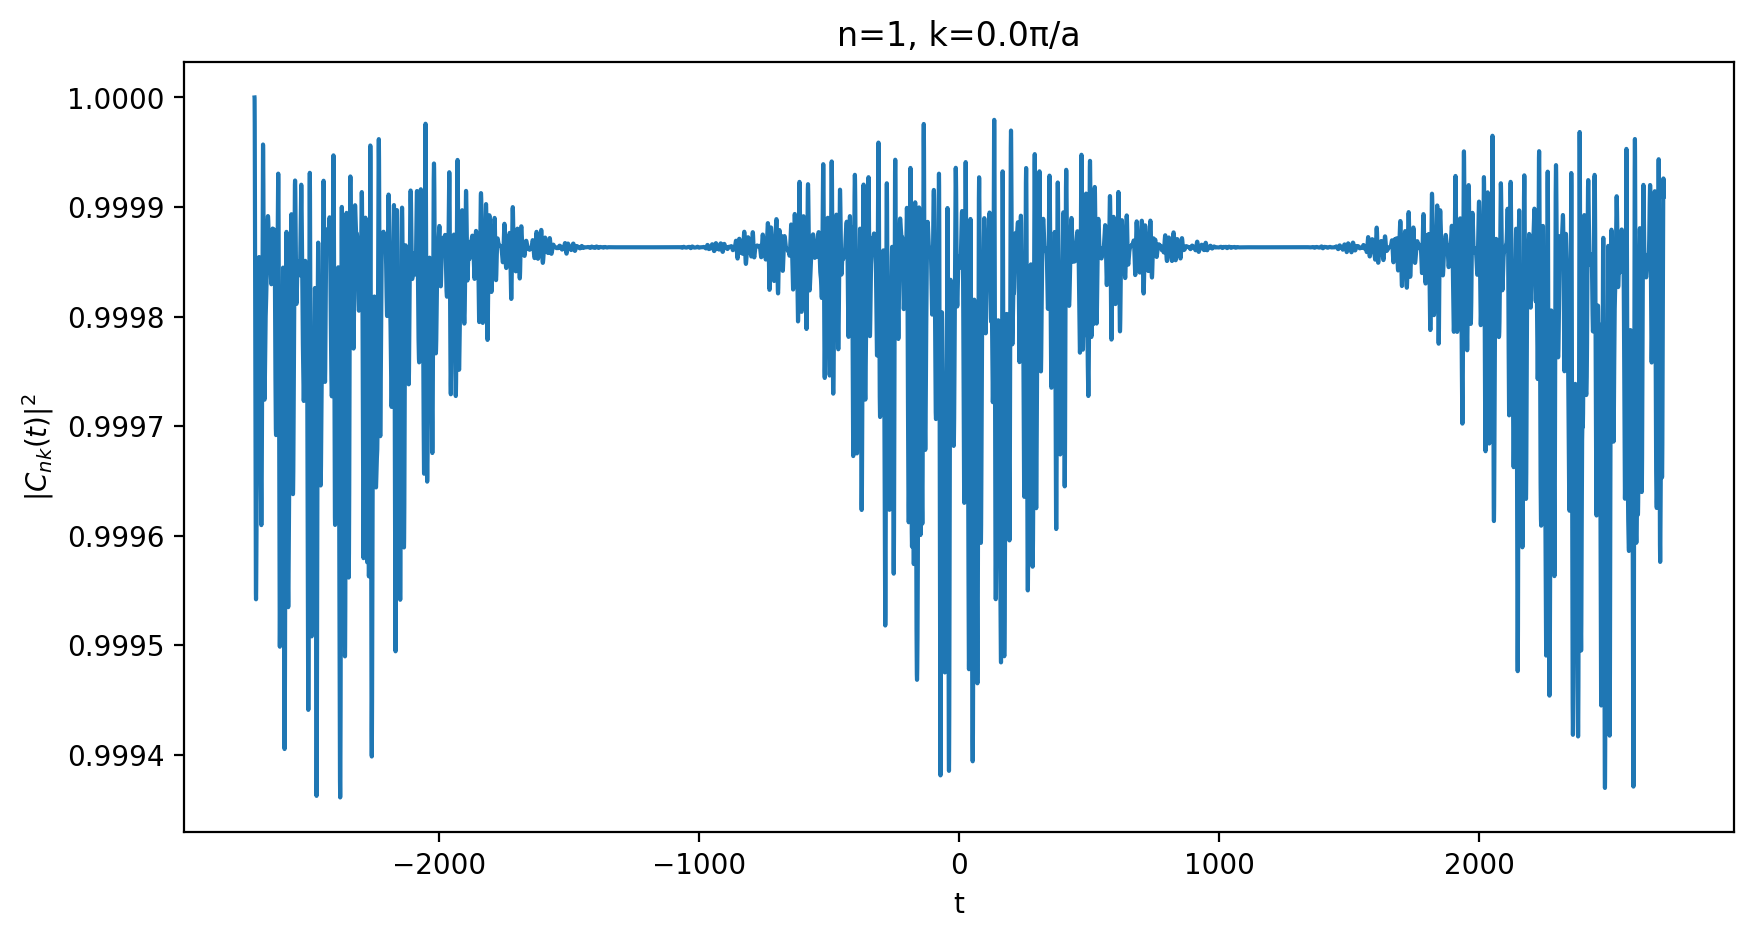

In [113]:
%%time
εX,εM = εXM(ε)
ik = len(K)//2
print(f'k = {K[ik]*a/π}π/a')
n = 1
C0 = np.zeros(Ψ.shape[-1])
C0[n] = 1

T,C = solve_tdse2D([t0,t1],δt,C0,K,ik,K,ik,εX,Ψ,a)
plt.figure(figsize=(10,5))
plt.title(f'n={n}, k={K[ik]*a/π}π/a')
plt.xlabel('t')
plt.ylabel(r'$|C_{nk}(t)|^2$')
plt.plot(T,np.abs(C[n])**2);

Recall that we are interested in computing
$$
I_\text{HHG} = \left|\left(j_\mathbf{k}(\omega)\right)_\mu\right|^2
$$

where
$$
\left(j_k(t)\right)_\mu = -\frac{e}{m}\left[\text{Re}\left(\sum_n\sum_{n'}C^*_{n\mathbf{k}}(t)C_{n'\mathbf{k}}(t)\left(p_\mathbf{k}^{nn'}\right)_\mu\right) + eA_\mu(t)\right]
$$

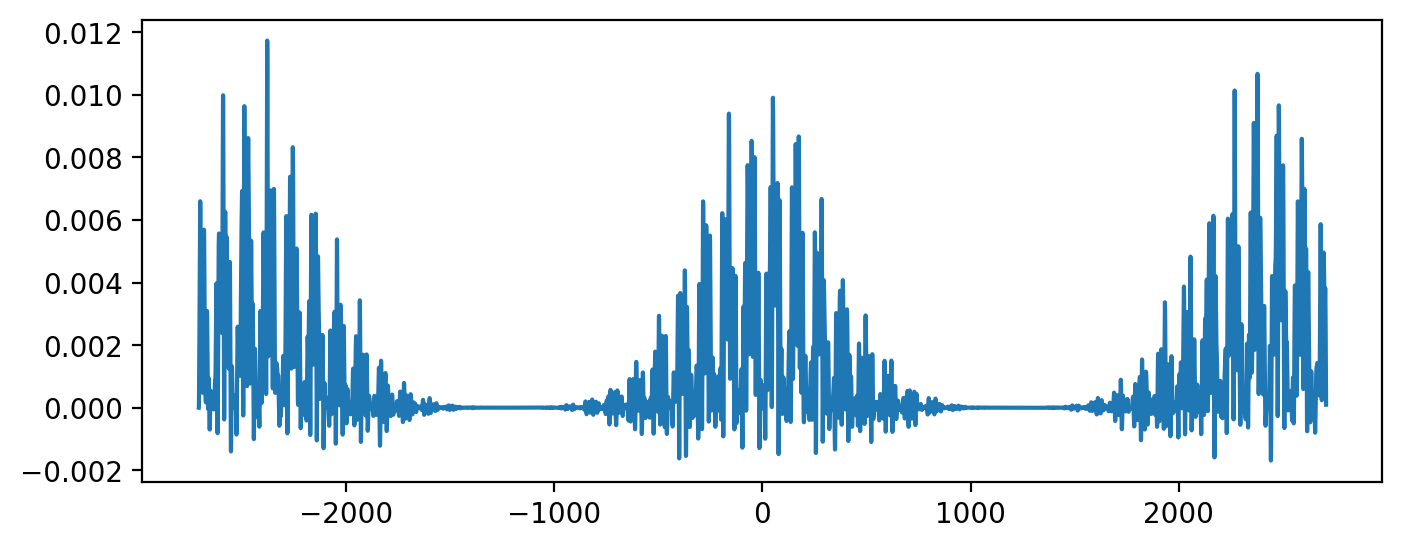

In [114]:
def construct_j2D(T,C,Kx,ikx,Ky,iky,Ψ,A,e=1,m=1):
    px,py = construct_p2D(ikx,Kx,iky,Ky,Ψ,a)
    Ax,Ay = A(T)
    ccp_x = np.einsum('ik,jk,ij->k', np.conj(C), C, px, dtype=complex)
    ccp_y = np.einsum('ik,jk,ij->k', np.conj(C), C, py, dtype=complex)
    jx = -e/m * (np.real(ccp_x) * e*Ax)
    jy = -e/m * (np.real(ccp_y) * e*Ay)
    return jx,jy    

Jx,Jy = construct_j2D(T,C,K,ik,K,ik,Ψ,A_Wu2D,a)
plt.plot(T,Jx);

/var/folders/zg/jxln9jd12cb4_fm_ptb9pk7w0000gn/T/ipykernel_25713/3210378996.py:6: RuntimeWarning: invalid value encountered in divide
  return Ω, np.abs( Jω/np.max(Jω) )**2


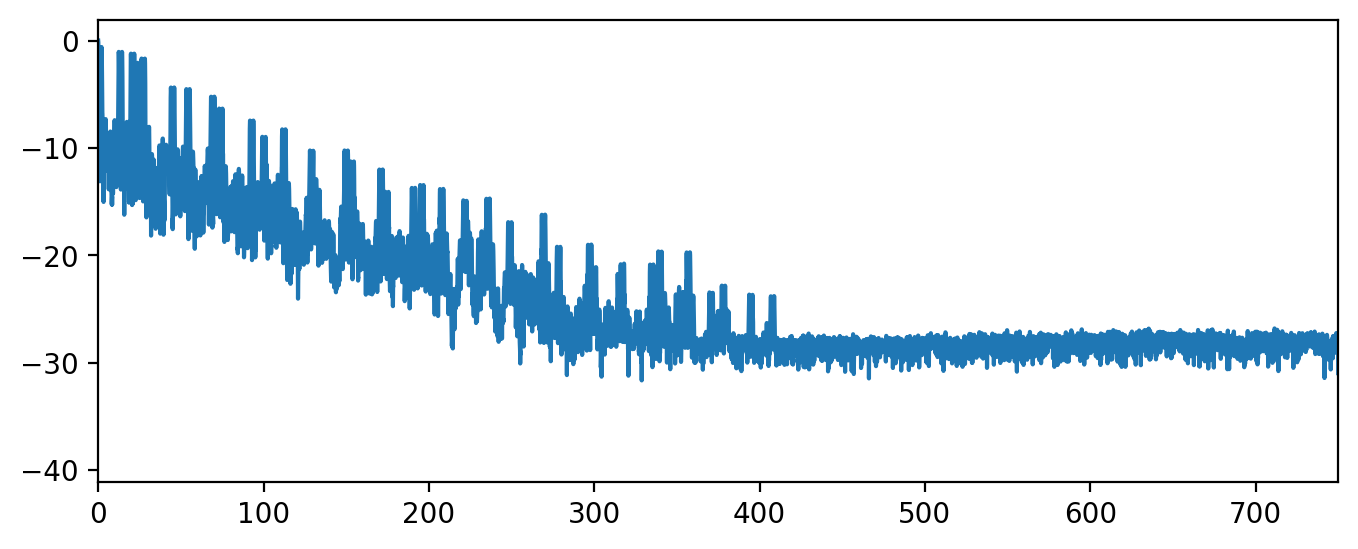

In [118]:
Ωx,Ix = I_HHG(Jx,δt)
Ωy,Iy = I_HHG(Jy,δt)

plt.xlim(0,750)
plt.plot(Ωx/ω0_Wu2D, np.log10(Ix));

Hey Mike. Hope all is going well. Was hoping to get a chat with you on the phone, could you let me know if you get a couple minutes?

- Going into last year, only need to take 2 courses + senior project
- Interest in data science/analytics
- Python and C# skills are blowing up - but trying to grow instead of building the nth web app
- Learned so much from LFX originally, is any work needed for the rest of the year.